# Linear fit of Bouguer lines on  AuxTel Data in one large wavelength bin for emplyt holo, PSF2DFFM


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : October 11th 2022
- update : October 16th 2022 : fit by poly1d, curve_fit
- update : October 17th 2022 : fit by ODR, iMunuit, matrix,analytical

** Kernel anaconda3_auxtel**

# Import

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec

%matplotlib inline
import pickle

In [2]:
import scipy.odr
import scipy.optimize

In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [4]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits',
 'comptable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits',
 'thermtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [5]:
import time
from datetime import datetime,date
from astropy.time import Time
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [6]:
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import fftpack
from scipy.optimize import curve_fit
from scipy.odr import Model,ODR,RealData
from scipy import linalg

In [7]:
# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

# display iminuit version
import iminuit
print("iminuit version:", iminuit.__version__)

iminuit version: 2.8.4


In [8]:
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES

In [9]:
HALPHA = Line(656.3, atmospheric=False, label='$H\\alpha$', label_pos=[-0.01, 0.02], use_for_calibration=True)
HBETA = Line(486.3, atmospheric=False, label='$H\\beta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA = Line(434.0, atmospheric=False, label='$H\\gamma$', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA = Line(410.2, atmospheric=False, label='$H\\delta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON = Line(397.0, atmospheric=False, label='$H\\epsilon$', label_pos=[0.001, 0.02], use_for_calibration=True)

HZETA = Line(388.9064, atmospheric=False, label='$H\\zeta$', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA = Line(383.5397, atmospheric=False, label='$H\\eta$', label_pos=[0.001, 0.02], use_for_calibration=False)

HBETA2 = Line(486.3*2, atmospheric=False, label='$H\\beta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA2 = Line(434.0*2, atmospheric=False, label='$H\\gamma$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA2 = Line(410.2*2, atmospheric=False, label='$H\\delta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON2 = Line(397.0*2, atmospheric=False, label='$H\\epsilon$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HZETA2 = Line(388.9064*2, atmospheric=False, label='$H\\zeta$2', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA2 = Line(383.5397*2, atmospheric=False, label='$H\\eta$2', label_pos=[0.001, 0.02], use_for_calibration=False)

O2_1 = Line(760.3, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3
O2_2 = Line(763.1, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3

O2B = Line(687.472, atmospheric=True, label=r'$O_2(B)$',  # 687.472 is a weighted average of the O2B line simulated by Libradtran
           label_pos=[0.001, 0.02], use_for_calibration=True)  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Y = Line(898.765, atmospheric=True, label=r'$O_2(Y)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Z = Line(822.696, atmospheric=True, label=r'$O_2(Z)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
# H2O = Line( 960,atmospheric=True,label='$H_2 O$',label_pos=[0.007,0.02],width_bounds=(1,50))  #
H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
              width_bounds=[5, 30])  # libradtran paper fig.3, broad line
ATMOSPHERIC_LINES = [O2_1, O2_2, O2B, O2Y, O2Z, H2O_1]


H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

my_calib_lines_etador = Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON,HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,O2_1,O2_2],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
hydrogen_lines_order1 =  Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON])
hydrogen_lines_order2 =  Lines([HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,HETA2])
oxygen_lines_order1 = Lines([O2_1,O2_2])

# Functions

- filtering here

https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

In [10]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

In [11]:
def atmpatt_Dataf_to_np(df):
    """
    
    atmpatt_Dataf_to_np : convert pandas dtaframe on abs pattern into numpy array
    
    """
    o2_cols = []
    for tabcol in df.columns:
        if 'o2_' in tabcol and 'no2_' not in tabcol:
            o2_cols.append(tabcol)
            
    no2_cols = []
    for tabcol in df.columns:
        if 'no2_' in tabcol:
            no2_cols.append(tabcol)
            
            
    h2o_cols = []
    for tabcol in df.columns:
        if 'h2o_' in tabcol:
            h2o_cols.append(tabcol)
            
            
    o3_cols = []
    for tabcol in df.columns:
        if 'o3_' in  tabcol:
            o3_cols.append(tabcol)
            
            
    data_wl = df["wl"].to_numpy()
    data_o2 = df[o2_cols].to_numpy()
    data_o3 = df[o3_cols].to_numpy()
    data_h2o = df[h2o_cols].to_numpy()
    data_no2 = df[no2_cols].to_numpy()
    
    
    return data_wl, data_o2, data_o3, data_h2o, data_no2
    
    

In [12]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [13]:
def GetSpectra(dict_spectra):
    """
    GetSpectra(dict_spectra)
    
    input:
      - dict_spectra : dictionnary of input spectra
      
      
      {'number': 238.0, 'object': 'mu. Col', 'dateobs': '2022-03-18T00:51:22.049', 'refhour': 0.0, 'airmass': 1.11557476948966, 'pressure': 743.45, 'temperature': 8.9, 
      'humidity': 48.0, 'targetx_pix': 312.7442668572934, 'targety_pix': 1738.0006619324693, 'rotangle': 0.1753951396614214, 'd2ccd': 181.0974436798836, 
      'all_lambdas': array([ 302.20970512,  302.91544585,  303.62117594, ..., 1108.67461764,
       1109.35162338, 1110.02859124]), 'all_fluxes': array([1.04110833e-13, 9.83856109e-14, 8.99209206e-14, ...,
       5.34113538e-13, 5.36905940e-13, 5.53127394e-13]), 'all_fluxes_err': array([3.51303583e-15, 3.10100695e-15, 2.58677333e-15, ...,
       3.34568263e-15, 4.01784054e-15, 4.54242555e-15]), 'all_lambdas_order2': array([ 302.24857475,  302.9543149 ,  303.66004442, ..., 1108.71192607,
       1109.38892974, 1110.06589555]), 'all_fluxes_order2': array([420.23653349, 386.95227531, 344.90384603, ...,  60.47440612,
        60.74615545,  62.53491353]), 'all_fluxes_err_order2': array([14.15542468, 12.17674916,  9.90751987, ...,  0.37846535,
        0.45415764,  0.51307916])}
      
    
    return
      - list of dataframes
    """
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0
    for key, value in dict_spectra.items():
        
        df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']]
         
        df = pd.DataFrame()
        df["all_lambdas"] = value["all_lambdas"]
        df["all_fluxes"] = value["all_fluxes"]
        df["all_fluxes_err"] = value["all_fluxes_err"]
        
        if 'all_lambdas_order2' in value.keys():
            df["all_lambdas_order2"] = value["all_lambdas_order2"]
            df["all_fluxes_order2"] = value["all_fluxes_order2"]
            df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
            
        
        all_df.append(df)
        
        
        idx+=1
        
    return df_info , all_df

In [14]:
def GetSpectraFiltered(dict_spectra,list_of_bad_spectra):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - dict_spectra
      - ist_of_bad_spectra
    
    return
      - filtered infos, filtered spectra
    """
    
    
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   
        

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0       # counter on input spectra
    idx_out = 0 # counter on save spectra
    for key, value in dict_spectra.items():
        
        
        if int(value["number"]) not in list_of_bad_spectra:
        
            
            df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']] 
        
            df = pd.DataFrame()
            df["all_lambdas"] = value["all_lambdas"]
            df["all_fluxes"] = value["all_fluxes"]
            df["all_fluxes_err"] = value["all_fluxes_err"]
        
            if 'all_lambdas_order2' in value.keys():
                df["all_lambdas_order2"] = value["all_lambdas_order2"]
                df["all_fluxes_order2"] = value["all_fluxes_order2"]
                df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
               
            all_df.append(df)
            idx_out+=1  # increase count on saved spectra
            
        else:
            num = int(value["number"])
            msg = f"Remove spectrum {idx} for exposure {num}"
            print(msg)
            
        idx+=1
            

        
    return df_info,all_df

In [15]:
def ConvertToImage(info, all_df,WLMIN=350,WLMAX=1100):
    """
    
    call 
    WL,Mags1,EMags1,AirM,Tim = ConvertToImage(info,all_spectra,WLMIN= WLMINSEL ,WLMAX= WLMAXSEL)  
    
    """
    
    N=len(all_df)
    WL=np.arange(WLMIN,WLMAX+1)
    NWL=len(WL)
    
    mag_table=np.zeros((N,NWL))   # table of  magnitudes
    emag_table=np.zeros((N,NWL))  # table of error on magnitudes
    
    
    airm_table=np.zeros(N)
    time_table=np.zeros(N)
    
    for idx in np.arange(N):
        df=all_df[idx]
        
        mag = -2.5*np.log10(df["all_fluxes"])
        errmag = 2.5/np.log(10) * df["all_fluxes_err"]/df["all_fluxes"]
        wavelength = df["all_lambdas"]
        fcn = interpolate.interp1d(wavelength,mag,bounds_error=False,fill_value=(0,0))
        fcn2 = interpolate.interp1d(wavelength,errmag,bounds_error=False,fill_value=(0,0))
            
        mag_table[idx,:] = fcn(WL) 
        emag_table[idx,:] = fcn2(WL) 
        
        airm_table[idx]  = info["airmass"].iloc[idx]
        time_table[idx]  = info["refhour"].iloc[idx]
        
    return WL, mag_table, emag_table,airm_table,time_table
       

In [16]:
def GetBouguerLinesTim(Npoints,wl,tim,magref ,emag,title="atmospheric transmission vs time",FLAG_PLOT=True,YMIN=0,YMAX=0,WLMIN=350,WLMAX=1100):
    """
    
    GetBouguerLinesTim(Npoints,wl,tim,magref ,emag,title="atmospheric transmission vs time",FLAG_PLOT=True,YMIN=0,YMAX=0):
    Input arguments :
    
    - Npoints : number of wavelength samples,
    - wl: array of wavelength
    - time : array of time
    - magref : reference of magnitudes array (2d)
    
    Return:
     plot only
    
    """
    
    # determine the wavelength output range
    if WLMIN == 0 and WLMAX == 0:
        WLMIN=wl.min()
        WLMAX=wl.max()
    
    # define the range of bin centers
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints,endpoint=True)
    # create label
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    
    
    # compute the bin width
    wl_binwidth1=(WLMAX-WLMIN)/(Npoints-1)
    wl_binwidth2=np.median(np.diff(wl_sel))
    wl_binwidth = wl_binwidth2
    
    
    # numbers of Bouguer lines
    NIWSEL=len(wl_sel)
    
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    # number of wavelength bins
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    # the abscisse is the time
    the_x=tim
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(16,10))
        ax=fig.add_subplot(111)

    # loop over bouguer lines (big wl bins)
    for idx in np.arange(N):     
        # central wavelength
        wl0=wl_sel[idx]
        
        # indexes in the input arrays
        idx_in_wlrange = np.where(np.logical_and(wl >= wl0-wl_binwidth/2,wl < wl0+wl_binwidth/2))[0]
        
        all_the_y_inwlbin=magref[:,idx_in_wlrange]
        all_the_ey_inwlbin=emag[:,idx_in_wlrange]   
        
        n_in_bin = len(all_the_y_inwlbin)
        
        # compute average
        the_y = np.median(all_the_y_inwlbin,axis=1)
        # compute error on average
        the_ey = np.sqrt(np.mean(all_the_ey_inwlbin**2,axis=1))/np.sqrt(n_in_bin)
        
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
            ax.errorbar(the_x,the_y,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 1., ecolor=all_colors[idx], elinewidth = 1.)
    
        
    
    
    if FLAG_PLOT:
        ax.legend(loc='upper right',bbox_to_anchor=(1.05,1))
        ax.set_xlim(0,the_x.max()*1.2)
        ax.grid()
        ax.set_xlabel("time (Hour)")
        ax.set_ylabel("magnitude")
        ax.set_title(title,fontsize=20,fontweight='bold')
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
        
     
    return 
     

In [17]:
def GetBouguerLinesAtm(Npoints,wl,airmass,magref ,emag,title="magnitude vs airmass",FLAG_PLOT=True,YMIN=0,YMAX=0,WLMIN=350,WLMAX=1100):
    """
    Compute bouguer lines in large bins
    
    input parameters:
        -  Npoints : Number of bouguer lines required in the bouguer lines
        -  wl array of wavelength at input
        - airmass array at input
        - magref : magnitude aray
        - emag :  magnitude error array
        
        
        
    return:
        - wl_sel,Mags,EMags,np.array(fit_flag),np.array(fit_results)
    """
    
    # determine the wavelength output range
    if WLMIN == 0 and WLMAX == 0:
        WLMIN=wl.min()
        WLMAX=wl.max()
    
    # define the range of bin centers
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints,endpoint=True)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    
    # compute the bin width
    wl_binwidth1=(WLMAX-WLMIN)/(Npoints-1)
    wl_binwidth2=np.median(np.diff(wl_sel))
    wl_binwidth = wl_binwidth2
    print("wl_binwidth = ",wl_binwidth)
    
    # numbers of Bouguer lines
    NIWSEL=len(wl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    
    # the absisse is the airmass 
    the_x=airmass
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(16,10))
        ax=fig.add_subplot(111)

        
    # loop on wavelength    
    fit_results = []
    fit_flag = []
    
    
    # loop on bouguer lines
    for idx in np.arange(N):
        
        # central wavelength
        wl0=wl_sel[idx]
        
        # indexes in the input arrays
        idx_in_wlrange = np.where(np.logical_and(wl >= wl0-wl_binwidth/2,wl < wl0+wl_binwidth/2))[0]
        
        all_the_y_inwlbin=magref[:,idx_in_wlrange]
        all_the_ey_inwlbin=emag[:,idx_in_wlrange]
        
        # number in wl bins
        n_in_bin = len(all_the_y_inwlbin)
        
        # compute the average
        the_y = np.median(all_the_y_inwlbin,axis=1)
        # compute error on the average
        the_ey = np.sqrt(np.mean(all_the_ey_inwlbin**2,axis=1))/np.sqrt(n_in_bin)
        
      
        # fit
        popt,cov = np.polyfit(the_x, the_y, 1,cov=True)
        fit_results.append(popt)
        
       
        
        perr=np.sqrt(np.diag(cov))
        nstd=1
        sigmaf=np.sqrt(x_fit**2*cov[0,0]+cov[1,1]+x_fit*(cov[0,1]+cov[1,0]))
        
        Mags[idx]=popt[-1]
        EMags[idx]=sigmaf[0]
        
        p = np.poly1d(popt)
        
        y_fit=p(x_fit)
        y_fit_up=y_fit+nstd*sigmaf
        y_fit_dw=y_fit-nstd*sigmaf
        
        if FLAG_PLOT:
       
            if popt[0] > 0 :
                # plot points
                ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
                ax.errorbar(the_x,the_y,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 1, ecolor=all_colors[idx], elinewidth =1)
    
                # plot fitted lines
                ax.plot(x_fit,y_fit,'-',color=all_colors[idx])
                ax.fill_between(x_fit,y_fit_up, y_fit_dw, alpha=.25, color="gray")
            
            else:
                msg = f"Remove wavelength {wl0} nm, bad fit slope = {popt[0]}, intercept = {popt[-1]}"
                print(msg)
            
                
        if popt[0] > 0 : 
            fit_flag.append(True) 
        else:
            fit_flag.append(False) 
                       
    
    
    if FLAG_PLOT:
        ax.legend(loc="upper right",bbox_to_anchor=(1.1,1))
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("magnitude")
        ax.set_title(title,fontsize=20,fontweight='bold')
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
     
    return wl_sel,Mags,EMags,np.array(fit_flag),np.array(fit_results)
     

In [18]:
def GetBouguerLinesAtmRelativetoZero(Npoints,wl,airmass,magref ,emag,title="magnitude vs airmass",FLAG_PLOT=True,YMIN=0,YMAX=0,WLMIN=350,WLMAX=1100):
    """
    
    Compute bouguer lines in large bins and remove zero-airmass magnitude
    
    input parameters:
        -  Npoints : Number of bouguer lines required in the bouguer lines
        -  wl array of wavelength at input
        - airmass array at input
        - magref : magnitude aray
        - emag :  magnitude error array
        
    return :
        - wl_sel,Mags,EMags,np.array(fit_flag),np.array(fit_results)
    
    """
    
    # determine the wavelength output range
    if WLMIN == 0 and WLMAX == 0:
        WLMIN=wl.min()
        WLMAX=wl.max()
    
    # define the range of bin centers
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints,endpoint=True)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    
    # compute the bin width
    wl_binwidth1=(WLMAX-WLMIN)/(Npoints-1)
    wl_binwidth2=np.median(np.diff(wl_sel))
    wl_binwidth = wl_binwidth2
    
    # numbers of Bouguer lines
    NIWSEL=len(wl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=airmass
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(16,10))
        ax=fig.add_subplot(111)

    # loop on Bouguer lines at different wavelength 
    fit_results = [] # contains the result of the fit popt
    fit_flag = []    # quality flag
    
    for idx in np.arange(N):
        
        
        # central wavelength
        wl0=wl_sel[idx]
        
        # indexes in the input arrays
        idx_in_wlrange = np.where(np.logical_and(wl >= wl0-wl_binwidth/2,wl < wl0+wl_binwidth/2))[0]
        
        all_the_y_inwlbin=magref[:,idx_in_wlrange]
        all_the_ey_inwlbin=emag[:,idx_in_wlrange]
        
        # number in wl bins
        n_in_bin = len(all_the_y_inwlbin)
        
        # compute the average
        the_y = np.median(all_the_y_inwlbin,axis=1)
        # compute error on the average
        the_ey = np.sqrt(np.mean(all_the_ey_inwlbin**2,axis=1))/np.sqrt(n_in_bin)
        
                    
    
        # fit
        popt,cov = np.polyfit(the_x, the_y, 1,cov=True)
        fit_results.append(popt)
        
        perr=np.sqrt(np.diag(cov))
        nstd=1
        sigmaf=np.sqrt(x_fit**2*cov[0,0]+cov[1,1]+x_fit*(cov[0,1]+cov[1,0]))
        
        Mags[idx]=popt[-1]
        EMags[idx]=sigmaf[0]
        
        p = np.poly1d(popt)
        
        y_fit=p(x_fit)
        y_fit_up=y_fit+nstd*sigmaf
        y_fit_dw=y_fit-nstd*sigmaf
        
        intercept =  popt[-1]
        
        
        
        if FLAG_PLOT:
            
            if popt[0] > 0 : 
                ax.plot(the_x,the_y - intercept,'+',color=all_colors[idx],label=wl_label[idx])
                ax.errorbar(the_x,the_y - intercept,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 1, ecolor=all_colors[idx], elinewidth =1)
            
                ax.plot(x_fit,y_fit - intercept,'-',color=all_colors[idx])
                ax.fill_between(x_fit,y_fit_up- intercept, y_fit_dw - intercept, alpha=.25, color="gray")
                
            
            else:
                msg = f"Remove wavelength {wl0}, bad fit slope = {popt[0]}, intercept = {popt[-1]}"
                print(msg)
               
       
        if popt[0] > 0 : 
            fit_flag.append(True) 
        else:
            fit_flag.append(False) 
            
    
    
    if FLAG_PLOT:
        ax.legend(loc="upper right",bbox_to_anchor=(1.1,1))
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("magnitude")
        ax.set_title(title,fontsize=20,fontweight='bold')
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
     
    return wl_sel,Mags,EMags,np.array(fit_flag),np.array(fit_results)
     

# Constants

# Initialisation

In [19]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [20]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2022-10-17 22:54:01,948 MacBook-Pro-de-admin.local __main__[82362] INFO LA time:13:54:01
2022-10-17 22:54:01,950 MacBook-Pro-de-admin.local __main__[82362] INFO NY time:16:54:01
2022-10-17 22:54:01,953 MacBook-Pro-de-admin.local __main__[82362] INFO London time:21:54:01
2022-10-17 22:54:01,955 MacBook-Pro-de-admin.local __main__[82362] INFO Paris time:22:54:01
2022-10-17 22:54:01,956 MacBook-Pro-de-admin.local __main__[82362] INFO ************************ START *********************


In [21]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [22]:
# config file
# --------------
#configfile = "config/default.ini"
configfile = "config/confprog_run-auxtel-holo-20220630-configPSF2DFFM_empty.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2022-10-17 22:54:01,969 MacBook-Pro-de-admin.local __main__[82362] INFO Configuration file : config/confprog_run-auxtel-holo-20220630-configPSF2DFFM_empty.ini


In [23]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2022-10-17 22:54:01,976 MacBook-Pro-de-admin.local __main__[82362] INFO 1) Configuration


In [24]:
config_section = config.sections()

In [25]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [26]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    
    SITE          = config['GENERAL']['SITE']
    DATE          = config['GENERAL']['DATE']
    
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
    
    filename_auxtelthroughput = config['GENERAL']['filename_auxtelthroughput']
    #filename_redfilter        = config['GENERAL']['filename_redfilter']
    filterdisperser =  config['GENERAL']['filterdisperser']
    
    spectractormode = config['GENERAL']['spectractormode']
    
    normalisationfactor = float(config['GENERAL']['normalisationfactor'])
                                
    correction_area = float(config['GENERAL']['correction_area'])                           
                                
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    
    WLBINWIDTH  =  float(config['GENERAL']['WLBINWIDTH'])
    
    NPOINTSVIEW       =    int(config['GENERAL']['NPOINTSVIEW']) 
    NPOINTSSAVE       =    int(config['GENERAL']['NPOINTSSAVE']) 
    outputfile_linearfit =  config['GENERAL']['outputfile_linearfit']
    outputfile_gp        =  config['GENERAL']['outputfile_gp']
    
    BADEXPOS = config['GENERAL']['BADEXPOS']
    
    FLAG_CORREC_GREY_ATT = bool(int(config['GENERAL']['FLAG_CORREC_GREY_ATT']))
    GREY_ATT_COEFS = config['GENERAL']['GREY_ATT_COEFS']
    
else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [27]:
msg=f" Object observed {target} at {SITE} ({DATE})"
logger.info(msg)

2022-10-17 22:54:02,011 MacBook-Pro-de-admin.local __main__[82362] INFO  Object observed HD142331 at AUXTEL/Rubin Obs (2022-06-30)


In [28]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

In [29]:
inputfile

'run-auxtel-holo-20220630-empty~holo4_003-config_DECONVOLUTION_PSF2DFFM.pickle'

In [30]:
list_of_badnums1 = [int(nn)  for nn in  BADEXPOS.split()]
list_of_badnums1

[368]

In [31]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

In [32]:
if FLAG_CORREC_GREY_ATT:
    list_of_greyattcoef = [locale.atof(val)  for val in GREY_ATT_COEFS.split()]
else:
    list_of_greyattcoef = []  

In [33]:
list_of_greyattcoef = np.array(list_of_greyattcoef)
list_of_greyattcoef

array([], dtype=float64)

In [34]:
len(list_of_greyattcoef)

0

In [35]:
WL= np.arange(WLMINSEL,WLMAXSEL)

# input files

## Get Calspec SED

- Notice we use a relative normalisation factor

In [36]:
s0=S.FileSpectrum(os.path.join(path_sed_calspec,sedfilename))

Warning, 62 of 6262 bins contained negative fluxes; they have been set to zero.


In [37]:
sed_w=s0.wave/10
sed_f=s0.flux*10*normalisationfactor
sed_idx=np.where(np.logical_and(sed_w>=WLMINSEL,sed_w<=WLMAXSEL))[0]
sed_w=sed_w[sed_idx]
sed_f=sed_f[sed_idx]

In [38]:
targetname = s0.fheader['TARGETID']

In [39]:
sed_m=-2.5*np.log10(sed_f)

Text(0, 0.5, 'mag')

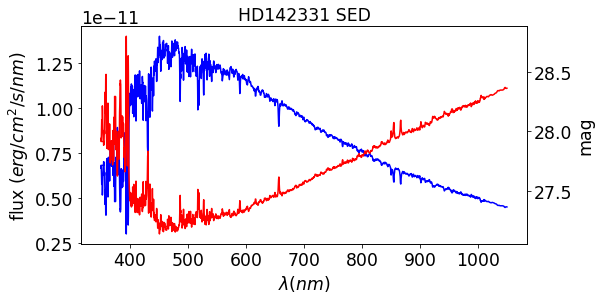

In [40]:
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.plot(sed_w,sed_f,'b')
ax.set_xlabel("$\\lambda (nm)$")
ax.set_ylabel("flux $(erg/cm^2/s/nm)$")
ax.set_title(targetname + " SED")
ax2=ax.twinx()
ax2.plot(sed_w,sed_m,'r-')
ax2.set_ylabel("mag")

## spectrum data

In [41]:
fullfilename=os.path.join(inputdir,inputfile)

In [42]:
with open(fullfilename, 'rb') as f:
    summary_content = pickle.load(f)

In [43]:
NBSPECTRA=len(summary_content)

In [44]:
msg=f" Number of selected files is {NBSPECTRA}"
logger.info(msg)

2022-10-17 22:54:02,688 MacBook-Pro-de-admin.local __main__[82362] INFO  Number of selected files is 40


In [45]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

### Read all files

In [46]:
infos, all_spectra = GetSpectra(summary_content)

In [47]:
infos.head()

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename,targetx_pix,targety_pix,rotangle,d2ccd
0,46,HD142331,2022-06-30T23:15:52.802,0.000000,1.402459,740.55,7.2,20.0,exposure_2022063000046_postisrccd_spectrum.fits,310.604358,1738.987547,0.249688,180.166828
1,106,HD142331,2022-06-30T23:57:15.887,0.689746,1.242285,740.45,6.9,22.0,exposure_2022063000106_postisrccd_spectrum.fits,306.708458,1735.261965,0.233171,180.189452
2,107,HD142331,2022-06-30T23:57:58.938,0.701704,1.240140,740.35,6.8,22.0,exposure_2022063000107_postisrccd_spectrum.fits,310.461907,1733.280084,0.244087,180.118370
3,121,HD142331,2022-07-01T00:07:07.542,0.854094,1.214369,740.30,6.7,22.0,exposure_2022063000121_postisrccd_spectrum.fits,311.279391,1734.388390,0.244799,180.080574
4,122,HD142331,2022-07-01T00:07:50.546,0.866040,1.212466,740.30,6.7,22.0,exposure_2022063000122_postisrccd_spectrum.fits,311.171350,1733.402647,0.294540,180.001588


In [48]:
all_spectra[0].head()

,all_lambdas,all_fluxes,all_fluxes_err,all_lambdas_order2,all_fluxes_order2,all_fluxes_err_order2
0,299.403839,2.272074e-14,6.644969e-15,299.361128,98.289254,28.795314
1,299.758511,1.674265e-14,4.525271e-15,299.715801,72.199336,19.550661
2,300.113181,1.131824e-14,2.999181e-15,300.070471,48.667239,12.913704
3,300.467848,7.104754e-15,4.057866e-15,300.425138,30.471535,17.412454
4,300.822512,-1.030486e-14,4.935220e-15,300.779803,-44.049007,21.112689


In [49]:
N=len(infos)
NX=4
NY=N/NX
if NY != int(NY):
    NY= int(NY)+1
else:
    NY=int(NY)

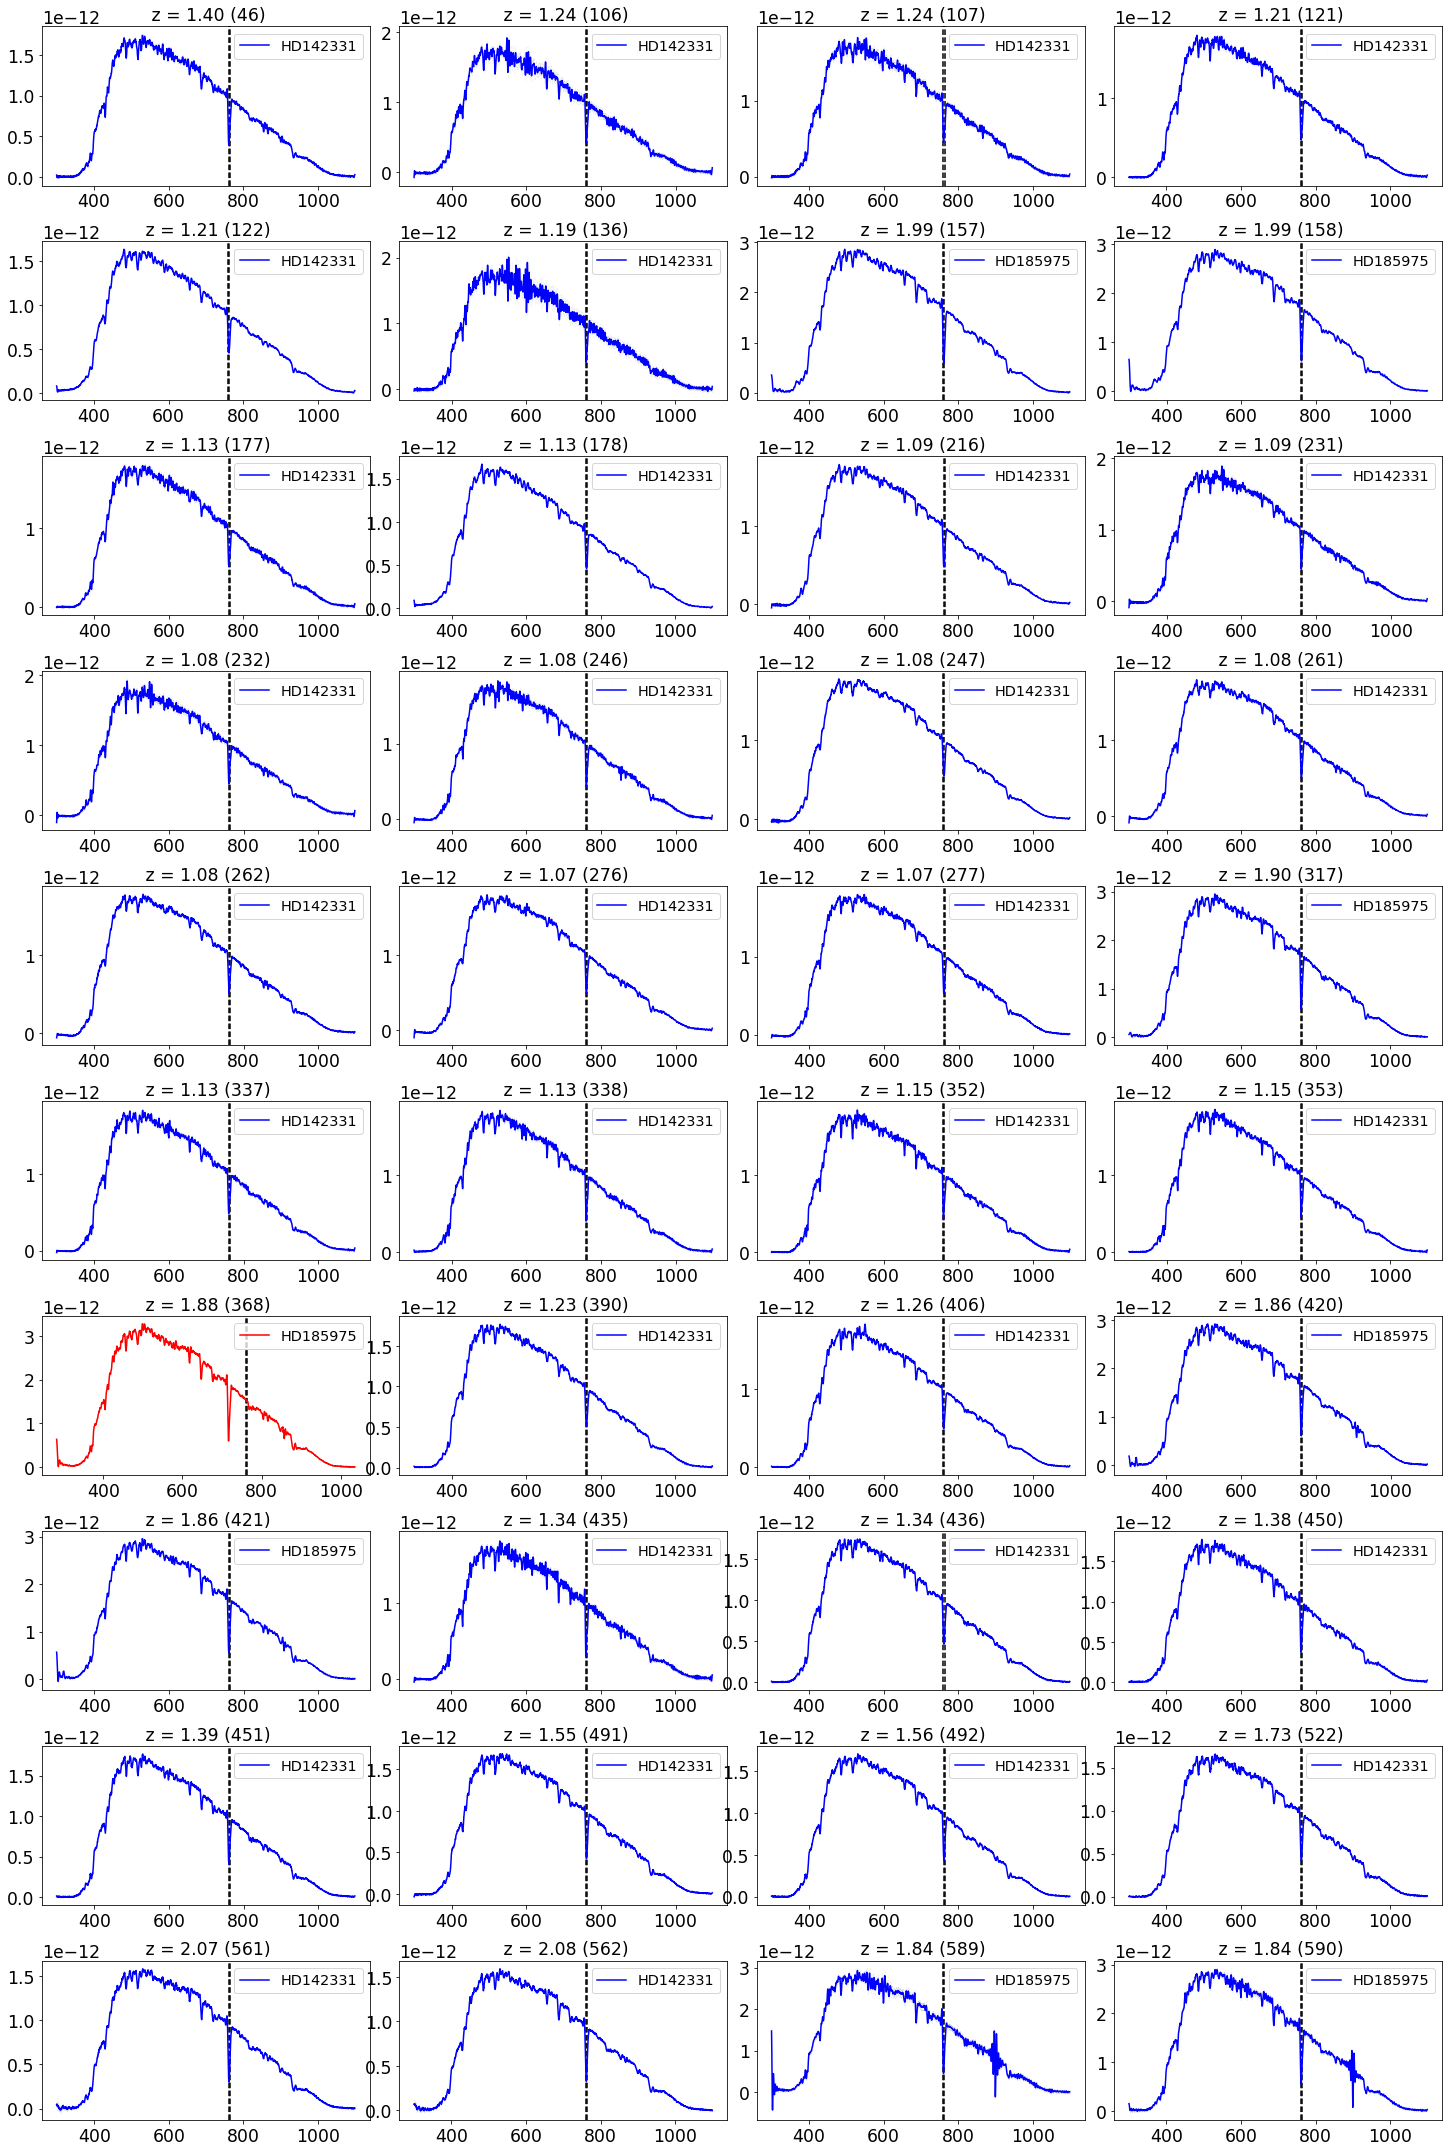

In [50]:
fig = plt.figure(figsize=(20,NY*3))

ny=0
nx=0

for idx in range(N):
    iy = idx//NX
    ix = (idx-iy*NX)
    
    ax=fig.add_subplot(NY,NX,idx+1)
    
    
    
    the_df=all_spectra[idx]
    
    airmassvalue = infos.iloc[idx]["airmass"]
    num = infos.iloc[idx]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    the_target = infos.iloc[idx]["object"]
    
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    if num in list_of_badnums1:
        thecolor="r"
    else:
        thecolor="b"
        
    # O2 line
    ax.axvline(O2_1.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '-', color=thecolor,capsize = 0.01, ecolor="k", elinewidth = .01,label=the_target)
    ax.set_title(label_airmass)
    ax.legend()
    
plt.tight_layout()

# Remove bad Spectra

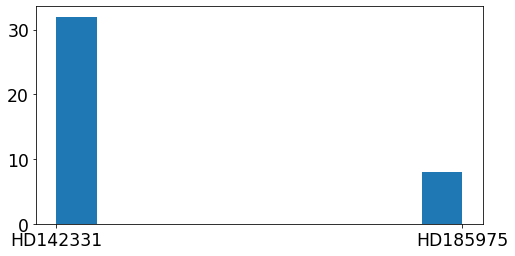

In [51]:
fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.hist(infos.object);

Text(0.5, 0.98, 'Variables to apply selection')

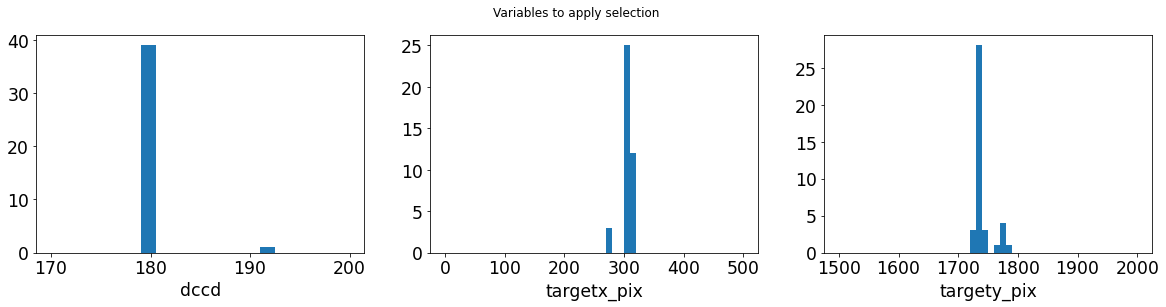

In [52]:
fig = plt.figure(figsize=(20,4))
ax=fig.add_subplot(1,3,1)
ax.hist(infos.d2ccd,bins=20,range=(170,200));
ax.set_xlabel("dccd")
ax=fig.add_subplot(1,3,2)
ax.hist(infos.targetx_pix,bins=50,range=(0,500));
ax.set_xlabel("targetx_pix")
ax=fig.add_subplot(1,3,3)
ax.hist(infos.targety_pix,bins=50,range=(1500,2000));
ax.set_xlabel("targety_pix")
plt.suptitle("Variables to apply selection")

## Define selection cut

In [53]:
#selection_cut = ((infos.d2ccd > 180) & (infos.d2ccd < 182)) & (infos.object == "mu. Col")
#bad_cut = ~selection_cut
#selection_cut = ((infos.d2ccd > 178) & (infos.d2ccd < 182)) & (infos.object == target)

selection_cut = ((infos.d2ccd > 178.5) & (infos.d2ccd < 181.5)) & (infos.object == target)
bad_cut = ~selection_cut

In [54]:
list_of_badnums2 = infos[bad_cut]["number"].values
list_of_badnums2 

array([157, 158, 317, 368, 420, 421, 589, 590])

## Union of badnums

In [55]:
list_of_badnums = np.union1d(list_of_badnums1,list_of_badnums2)
list_of_badnums=np.unique(list_of_badnums)

In [56]:
infos, all_spectra = GetSpectraFiltered(summary_content,list_of_bad_spectra=list_of_badnums)

Remove spectrum 6 for exposure 157
Remove spectrum 7 for exposure 158
Remove spectrum 19 for exposure 317
Remove spectrum 24 for exposure 368
Remove spectrum 27 for exposure 420
Remove spectrum 28 for exposure 421
Remove spectrum 38 for exposure 589
Remove spectrum 39 for exposure 590


In [57]:
print("Number of spectra : ",len(all_spectra))

Number of spectra :  32


In [58]:
infos.reset_index(drop=True, inplace=True)

In [59]:
infos

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename,targetx_pix,targety_pix,rotangle,d2ccd
0,46,HD142331,2022-06-30T23:15:52.802,0.000000,1.402459,740.55,7.2,20.0,exposure_2022063000046_postisrccd_spectrum.fits,310.604358,1738.987547,0.249688,180.166828
1,106,HD142331,2022-06-30T23:57:15.887,0.689746,1.242285,740.45,6.9,22.0,exposure_2022063000106_postisrccd_spectrum.fits,306.708458,1735.261965,0.233171,180.189452
2,107,HD142331,2022-06-30T23:57:58.938,0.701704,1.240140,740.35,6.8,22.0,exposure_2022063000107_postisrccd_spectrum.fits,310.461907,1733.280084,0.244087,180.118370
3,121,HD142331,2022-07-01T00:07:07.542,0.854094,1.214369,740.30,6.7,22.0,exposure_2022063000121_postisrccd_spectrum.fits,311.279391,1734.388390,0.244799,180.080574
4,122,HD142331,2022-07-01T00:07:50.546,0.866040,1.212466,740.30,6.7,22.0,exposure_2022063000122_postisrccd_spectrum.fits,311.171350,1733.402647,0.294540,180.001588
5,136,HD142331,2022-07-01T00:17:03.362,1.019600,1.189474,740.35,6.5,23.0,exposure_2022063000136_postisrccd_spectrum.fits,300.041157,1738.538441,0.240702,180.084899
6,177,HD142331,2022-07-01T00:49:00.740,1.552205,1.128326,740.25,6.1,23.0,exposure_2022063000177_postisrccd_spectrum.fits,308.363321,1742.433014,0.244863,180.137870
7,178,HD142331,2022-07-01T00:49:43.755,1.564154,1.127250,740.25,6.1,23.0,exposure_2022063000178_postisrccd_spectrum.fits,305.675291,1743.951746,0.266578,179.966904
8,216,HD142331,2022-07-01T01:19:34.765,2.061656,1.092662,740.25,5.6,25.0,exposure_2022063000216_postisrccd_spectrum.fits,310.969425,1734.639237,0.236186,180.111233
9,231,HD142331,2022-07-01T01:29:30.756,2.227209,1.085327,740.15,5.3,26.0,exposure_2022063000231_postisrccd_spectrum.fits,307.233352,1735.108951,0.232267,180.277306


/Users/dagoret/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


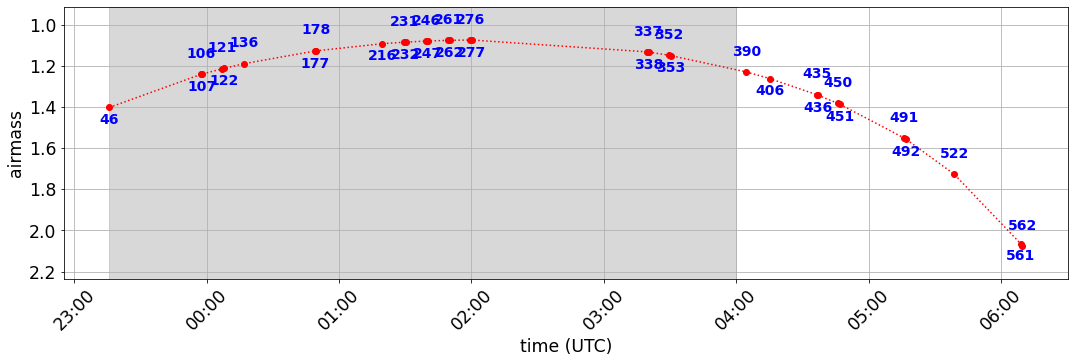

In [60]:
all_datetime = [ Time(str_time).to_datetime() for str_time in infos['dateobs'] ]
numbers = infos['number'].values
airmasses = infos['airmass'].values
N= len(numbers)

myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)


# Create rectangle x coordinates
startTime = all_datetime[0]
endTime =  datetime(2022, 7, 1, 4, 0, 0, 0),

# convert to matplotlib date representation
start = mdates.date2num(startTime)
end = mdates.date2num(endTime)
width = end - start



fig=plt.figure(figsize=(18,5))
ax=fig.add_subplot(111)
#ax.plot(all_datetime,grey_attenuation,'bo:')
#ax.grid()
#plt.gcf().autofmt_xdate()
#ax.xaxis.set_major_formatter(myFmt)
#ax.xaxis.set_tick_params(rotation=45)
#ax.set_xlabel("time (UTC)")
#ax.set_title(f"Grey attenuation : {DATE} ({filterdisperser}, {target})")
#ax.set_ylabel("attenuation")
#ax2 = ax.twinx()

y_shift= 0.08

ax2=ax
ax2.plot(all_datetime,airmasses,'r:o')
ax2.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_tick_params(rotation=45)
ax2.set_xlabel("time (UTC)")
ax2.set_ylabel("airmass")
ax2.set_ylim(airmasses.min()-2*y_shift,airmasses.max()+2*y_shift)
# Plot rectangle
rect = plt.Rectangle((start, airmasses.min()-2*y_shift), width, airmasses.max()+ 2*y_shift, color='grey',alpha=0.3)
ax2.add_patch(rect)   
ax2.invert_yaxis()
ax2.grid()


for index in range(N):
    textstr= str(numbers[index])
    if index%2 == 0:
        dy = y_shift
    else:
        dy = -y_shift
            
    ax2.text(all_datetime[index], airmasses[index] + dy , textstr,fontsize=14,fontweight="bold",ha='center',color="b" )
    
import matplotlib.dates as mdates





# Correct spectra for grey attenuation

In [61]:
NBSPECTRA = len(all_spectra)

In [62]:
assert NBSPECTRA == len(infos)

In [63]:
NBSPECTRA

32

In [64]:
len(list_of_greyattcoef)

0

In [65]:
def GetCorrectedGreyAttSpectra(in_infos,in_all_spectra,in_list_ofgreyattcoef):
    """
    """
    out_infos = in_infos
    out_infos["greyatt"] = in_list_ofgreyattcoef
    out_all_spectra = []
    
    idx=0
    for specdf in in_all_spectra:
        specdf['all_fluxes'] = specdf['all_fluxes'].multiply(1./in_list_ofgreyattcoef[idx])
        specdf['all_fluxes_err'] = specdf['all_fluxes_err'].multiply(1./in_list_ofgreyattcoef[idx])
        out_all_spectra.append(specdf)
    return out_infos, out_all_spectra
        

In [66]:
all_spectra[0].head()

,all_lambdas,all_fluxes,all_fluxes_err,all_lambdas_order2,all_fluxes_order2,all_fluxes_err_order2
0,299.403839,2.272074e-14,6.644969e-15,299.361128,98.289254,28.795314
1,299.758511,1.674265e-14,4.525271e-15,299.715801,72.199336,19.550661
2,300.113181,1.131824e-14,2.999181e-15,300.070471,48.667239,12.913704
3,300.467848,7.104754e-15,4.057866e-15,300.425138,30.471535,17.412454
4,300.822512,-1.030486e-14,4.935220e-15,300.779803,-44.049007,21.112689


In [67]:
if FLAG_CORREC_GREY_ATT:
    assert NBSPECTRA == len(list_of_greyattcoef)
    infos,all_spectra = GetCorrectedGreyAttSpectra(infos,all_spectra,list_of_greyattcoef)
else:
    list_of_greyattcoef = np.full(NBSPECTRA,1.)

In [68]:
all_spectra[0].head()

,all_lambdas,all_fluxes,all_fluxes_err,all_lambdas_order2,all_fluxes_order2,all_fluxes_err_order2
0,299.403839,2.272074e-14,6.644969e-15,299.361128,98.289254,28.795314
1,299.758511,1.674265e-14,4.525271e-15,299.715801,72.199336,19.550661
2,300.113181,1.131824e-14,2.999181e-15,300.070471,48.667239,12.913704
3,300.467848,7.104754e-15,4.057866e-15,300.425138,30.471535,17.412454
4,300.822512,-1.030486e-14,4.935220e-15,300.779803,-44.049007,21.112689


In [69]:
def plotlines(ax,ypos):
    
    ax.axvline(HDELTA.wavelength,color='orange')
    ax.annotate(HDELTA.label, xy=(HDELTA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HGAMMA.wavelength,color='orange')
    ax.annotate(HGAMMA.label, xy=(HGAMMA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HBETA.wavelength,color='orange')
    ax.annotate(HBETA.label, xy=(HBETA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HALPHA.wavelength,color='orange')
    ax.annotate(HALPHA.label, xy=(HALPHA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')

    ax.axvline(O2B.wavelength,color="blue")
    ax.annotate(O2B.label, xy=(O2B.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_1.wavelength,color="blue")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,color="blue")
    ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(H2O_1.wavelength,color="blue")
    ax.annotate(H2O_1.label, xy=(H2O_1.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.axvline(H2O_2.wavelength,color="blue")
    ax.annotate(H2O_2.label, xy=(H2O_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    

In [70]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [71]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

2022-10-17 22:54:13,361 MacBook-Pro-de-admin.local __main__[82362] INFO  Number of good spectra is 32


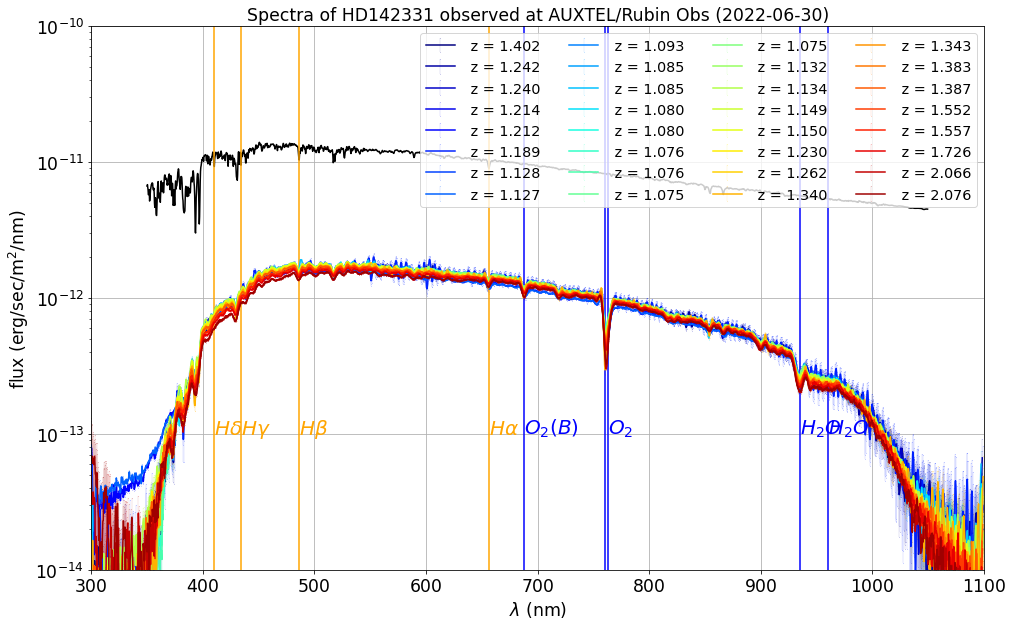

In [72]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.3f}"
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df.all_lambdas,the_df.all_fluxes,yerr=the_df.all_fluxes_err, fmt = '-', color=all_colors[ifile],capsize = 0.1, ecolor=all_colors[ifile], elinewidth = .1,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title)
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(300,1100)
ax.set_ylim(1e-14,1e-10)
ax.set_yscale("log")
ax.legend(loc="upper right",ncol=4)

plotlines(ax,1e-13)

# Convert Not filtered spectra into Mag table

In [73]:
WL,Mags1,EMags1,AirM,Tim = ConvertToImage(infos,all_spectra,WLMIN= WLMINSEL ,WLMAX= WLMAXSEL)

/Users/dagoret/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


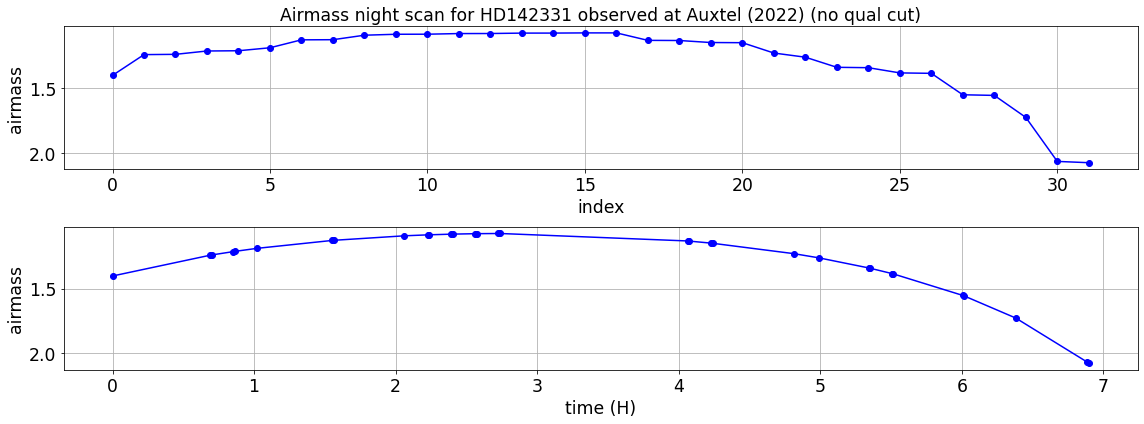

In [74]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_subplot(211)
ax1.plot(AirM,"bo-")
ax1.set_ylabel("airmass")
ax1.set_xlabel("index")
title=f"Airmass night scan for {target} observed at Auxtel (2022) (no qual cut)"
ax1.set_title(title)
ax1.grid()
ax1.invert_yaxis()

ax2=fig.add_subplot(212)
ax2.plot(Tim,AirM,"bo-")
ax2.set_ylabel("airmass")
ax2.set_xlabel("time (H)")
ax2.grid()
ax2.invert_yaxis()
plt.tight_layout()


In [75]:
fcn_sed_mag0 = interpolate.interp1d(sed_w,sed_m,bounds_error=False,fill_value=(0,0))
sed_mag0 =fcn_sed_mag0(WL)

In [76]:
MagsRef1=Mags1-sed_mag0
title="instrumental magnitude - sed magnitude vs time"

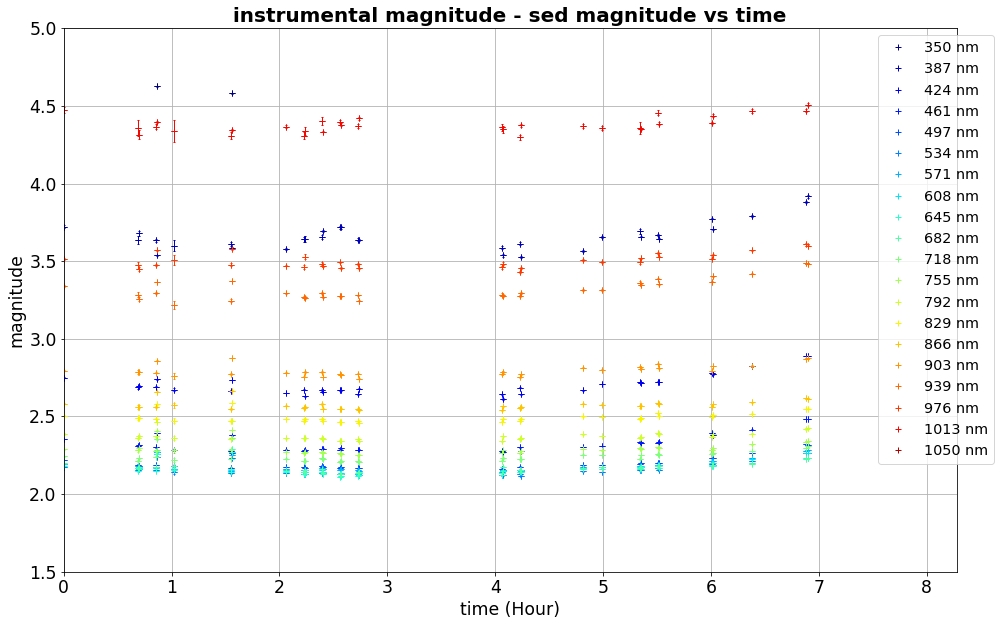

In [77]:
GetBouguerLinesTim(NPOINTSVIEW,WL,Tim,MagsRef1,EMags1,title=title,FLAG_PLOT=True,YMIN=1.5,YMAX=5,WLMIN=WLMINSEL,WLMAX=WLMAXSEL)

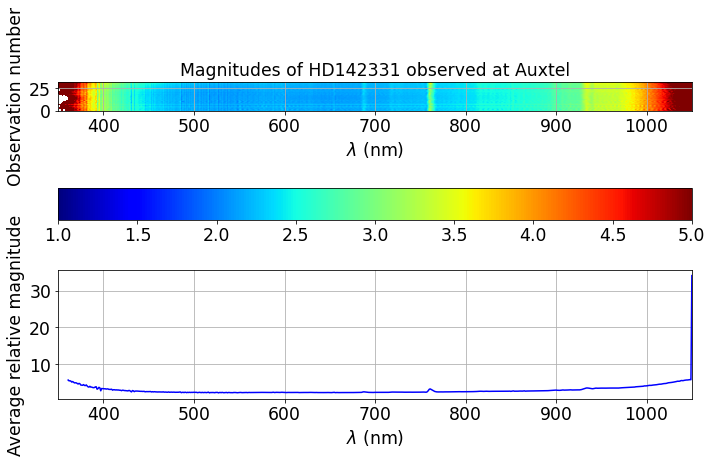

In [78]:
fig=plt.figure(figsize=(10,10))

gs = fig.add_gridspec(2, 1,height_ratios=[4,1])

ax1=fig.add_subplot(gs[0, :])

extent=(WL.min(),WL.max(),0,NBSPECTRA)
norm = mpl.colors.Normalize(vmin=1, vmax=5)
im=ax1.imshow(MagsRef1,origin="lower",norm=norm,extent=extent,cmap="jet")
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), ax=ax1, orientation="horizontal" )
ax1.grid()
ax1.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel("Observation number")
title=f"Magnitudes of {target} observed at Auxtel"
ax1.set_title(title)


ax2=fig.add_subplot(gs[1, :],sharex=ax1)

Y=np.average(MagsRef1,axis=0)
ax2.plot(WL,Y,"b-")
#ax2.set_ylim(2,4)
ax2.set_xlabel("$\lambda$ (nm)")
ax2.set_ylabel("Average relative magnitude")
ax2.grid()
plt.tight_layout()

# Filtered spectra

In [79]:
list_of_badnums

array([157, 158, 317, 368, 420, 421, 589, 590])

In [80]:
numbers=infos["number"].values
numbers

array([ 46, 106, 107, 121, 122, 136, 177, 178, 216, 231, 232, 246, 247,
       261, 262, 276, 277, 337, 338, 352, 353, 390, 406, 435, 436, 450,
       451, 491, 492, 522, 561, 562])

In [81]:
# Marc selection October 11th 2022
#list_of_badnums = [46, 106, 107, 121, 122, 136,157, 158, 177, 178, 216, 231, 232, 246, 247, 261, 262, 276,277, 317, 
#                   337, 338, 352, 353 ,368, 420, 421, 450,589, 590 ]

In [82]:
idx_to_remove = np.where(numbers < 390)[0] 
numbers_to_remove = numbers[idx_to_remove]
print("numbers_to_remove=",numbers_to_remove) 
list_of_badnums = np.unique(np.union1d(list_of_badnums,numbers_to_remove))
print("list_of_badnums",list_of_badnums)

numbers_to_remove= [ 46 106 107 121 122 136 177 178 216 231 232 246 247 261 262 276 277 337
 338 352 353]
list_of_badnums [ 46 106 107 121 122 136 157 158 177 178 216 231 232 246 247 261 262 276
 277 317 337 338 352 353 368 420 421 589 590]


In [83]:
infos, all_spectra = GetSpectraFiltered(summary_content,list_of_bad_spectra=list_of_badnums)

Remove spectrum 0 for exposure 46
Remove spectrum 1 for exposure 106
Remove spectrum 2 for exposure 107
Remove spectrum 3 for exposure 121
Remove spectrum 4 for exposure 122
Remove spectrum 5 for exposure 136
Remove spectrum 6 for exposure 157
Remove spectrum 7 for exposure 158
Remove spectrum 8 for exposure 177
Remove spectrum 9 for exposure 178
Remove spectrum 10 for exposure 216
Remove spectrum 11 for exposure 231
Remove spectrum 12 for exposure 232
Remove spectrum 13 for exposure 246
Remove spectrum 14 for exposure 247
Remove spectrum 15 for exposure 261
Remove spectrum 16 for exposure 262
Remove spectrum 17 for exposure 276
Remove spectrum 18 for exposure 277
Remove spectrum 19 for exposure 317
Remove spectrum 20 for exposure 337
Remove spectrum 21 for exposure 338
Remove spectrum 22 for exposure 352
Remove spectrum 23 for exposure 353
Remove spectrum 24 for exposure 368
Remove spectrum 27 for exposure 420
Remove spectrum 28 for exposure 421
Remove spectrum 38 for exposure 589
Rem

In [84]:
infos

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename,targetx_pix,targety_pix,rotangle,d2ccd
25,390,HD142331,2022-07-01T04:04:36.690,4.812191,1.230062,740.25,4.4,21.0,exposure_2022063000390_postisrccd_spectrum.fits,312.520709,1734.210910,0.250870,179.999437
26,406,HD142331,2022-07-01T04:15:09.517,4.987976,1.262168,740.35,4.5,21.0,exposure_2022063000406_postisrccd_spectrum.fits,307.896679,1734.036890,0.250728,180.072916
29,435,HD142331,2022-07-01T04:36:21.650,5.341347,1.340136,740.25,4.5,18.0,exposure_2022063000435_postisrccd_spectrum.fits,311.611887,1734.152839,0.245338,180.118634
30,436,HD142331,2022-07-01T04:37:04.566,5.353268,1.343110,740.25,4.5,18.0,exposure_2022063000436_postisrccd_spectrum.fits,310.032724,1734.322237,0.253949,180.125239
31,450,HD142331,2022-07-01T04:46:09.610,5.504669,1.383281,740.20,4.4,18.0,exposure_2022063000450_postisrccd_spectrum.fits,307.420955,1733.238072,0.253893,180.128676
32,451,HD142331,2022-07-01T04:46:52.627,5.516618,1.386636,740.25,4.4,18.0,exposure_2022063000451_postisrccd_spectrum.fits,304.879111,1735.356270,0.259295,180.152049
33,491,HD142331,2022-07-01T05:16:13.085,6.005634,1.551907,740.15,4.4,18.0,exposure_2022063000491_postisrccd_spectrum.fits,311.048411,1739.496461,0.266471,180.093004
34,492,HD142331,2022-07-01T05:16:56.063,6.017573,1.556733,740.15,4.4,18.0,exposure_2022063000492_postisrccd_spectrum.fits,310.844972,1738.665036,0.262157,180.142832
35,522,HD142331,2022-07-01T05:38:40.862,6.380017,1.726255,740.25,4.3,17.0,exposure_2022063000522_postisrccd_spectrum.fits,309.673975,1728.259463,0.261795,180.076154
36,561,HD142331,2022-07-01T06:08:58.076,6.884798,2.065672,740.15,4.2,17.0,exposure_2022063000561_postisrccd_spectrum.fits,314.719563,1735.613816,0.248362,180.030478


# Convert Not filtered spectra into Mag table

In [85]:
NBSPECTRA=len(all_spectra)

In [86]:
assert NBSPECTRA == len(infos)

In [87]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [88]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

2022-10-17 22:54:23,972 MacBook-Pro-de-admin.local __main__[82362] INFO  Number of good spectra is 11


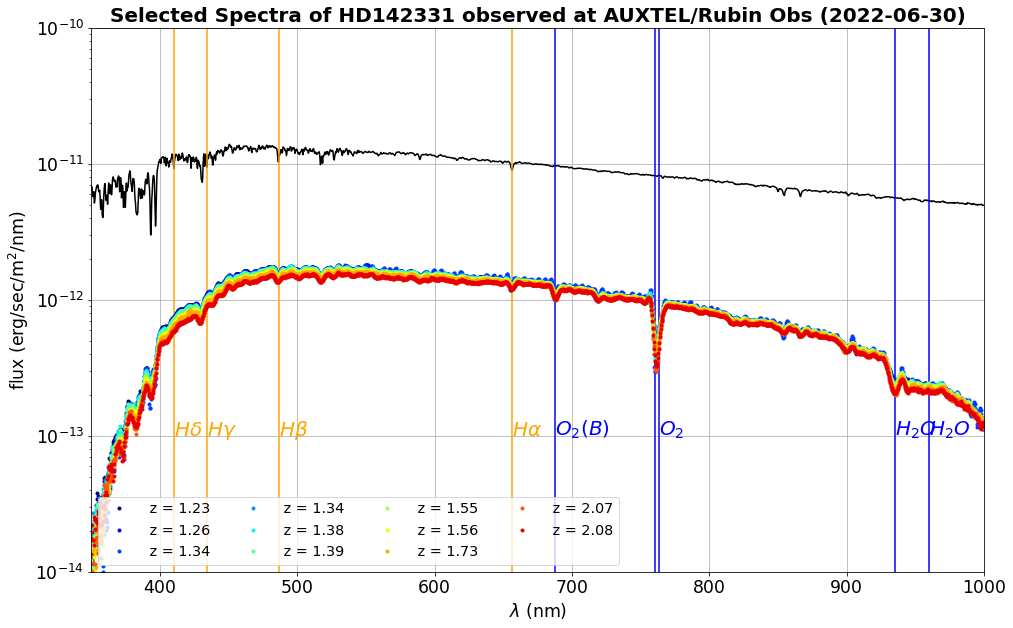

In [89]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(350,1000)
ax.set_ylim(1e-14,1e-10)
ax.set_yscale("log")
ax.legend(loc="lower left",ncol=4)
plotlines(ax,1e-13)

In [90]:
df = pd.read_csv("data/absorption_pattern.csv")
wlpt,o2,o3,h2o,no2 = atmpatt_Dataf_to_np(df)

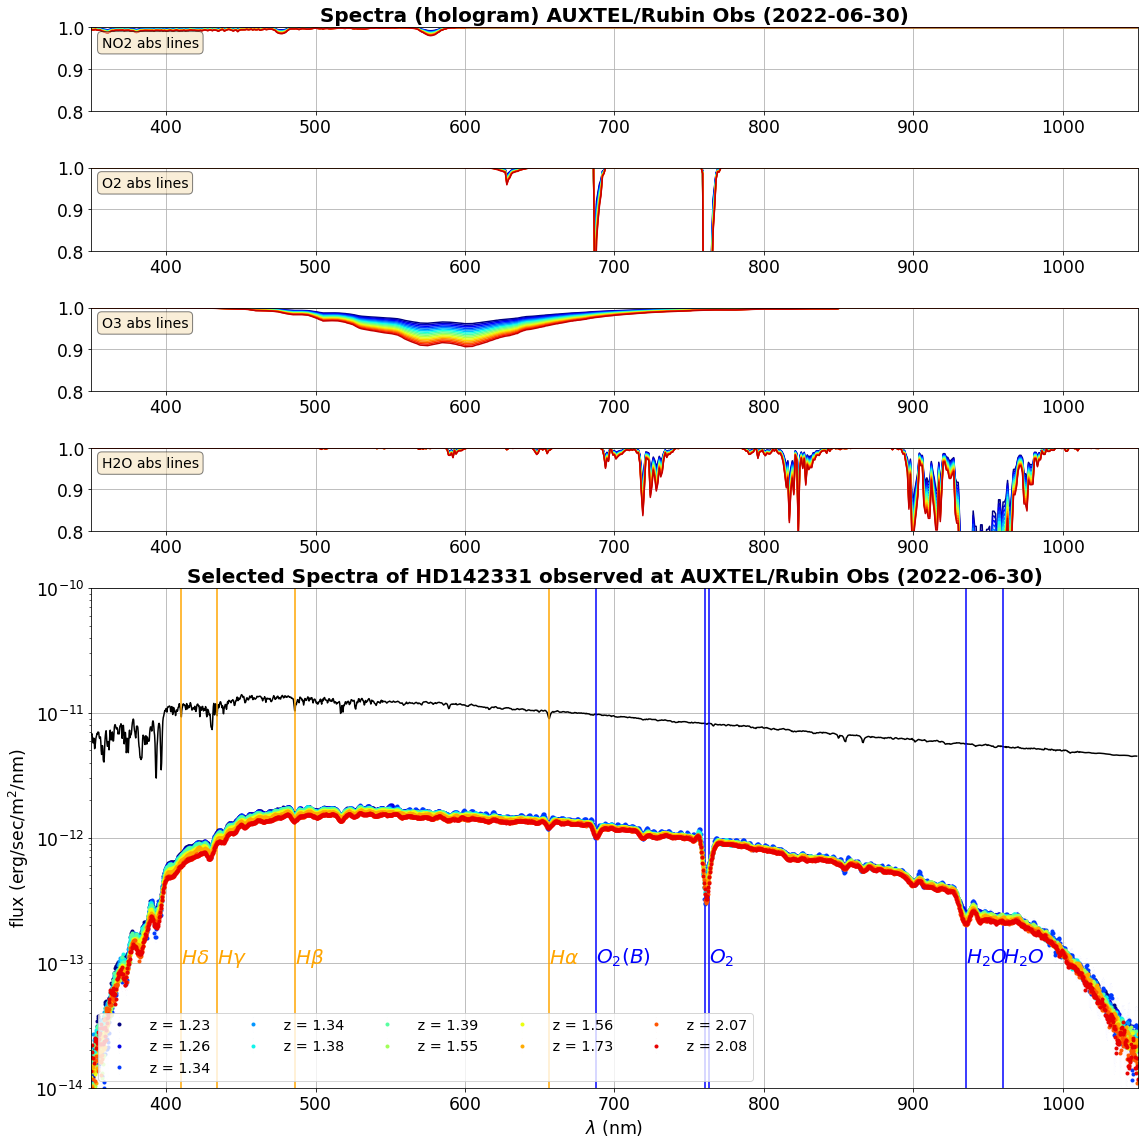

In [91]:
figsize=(16,16)

NOBS = o2.shape[1]
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig=plt.figure(figsize=figsize)
title =f"Spectra (hologram) {SITE} ({DATE})"


gs = gridspec.GridSpec(5, 1,height_ratios=[0.5,0.5,0.5,0.5,3] ,figure=fig)

# NO2    
ax=fig.add_subplot(gs[0,0])
for index in np.arange(NOBS):   
    ax.plot(wlpt,no2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "NO2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_title(title,fontsize=20,fontweight='bold')
main_ax = ax



# O2    
ax=fig.add_subplot(gs[1,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
#ax.set_title(title)


# Ozone
ax=fig.add_subplot(gs[2,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o3[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O3 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# H2O
ax=fig.add_subplot(gs[3,0], sharex=main_ax)

for index in np.arange(NOBS):   
    ax.plot(wlpt,h2o[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.grid()
textstr = "H2O abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# spectrum
ax=fig.add_subplot(gs[4,0], sharex=main_ax)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-')
#ax.set_xlim(350,1000)
ax.set_ylim(1e-14,1e-10)
ax.set_yscale("log")
ax.legend(loc="lower left",ncol=5)
plotlines(ax,1e-13)
plt.tight_layout()


/Users/dagoret/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dagoret/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dagoret/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dagoret/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dagoret/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dagoret/anaconda3/lib/python3.9/site-packages/pandas/core/

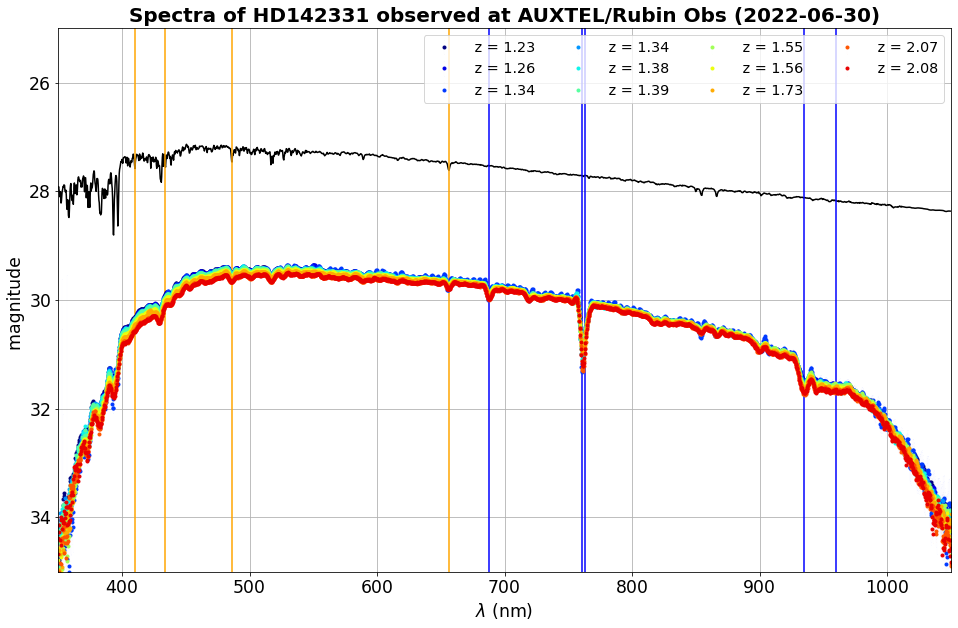

In [92]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=the_df=all_spectra[ifile]

    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"
    
    #ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
    mag = -2.5*np.log10(the_df["all_fluxes"])
    errmag = 2.5/np.log(10)*the_df["all_fluxes_err"]/(the_df["all_fluxes"])
    ax.errorbar(the_df["all_lambdas"],mag,yerr=errmag, fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude ")
title=f"Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_m,'k-')
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_ylim(25,35)
ax.invert_yaxis()
ax.legend(loc="upper right",ncol=4)
plotlines(ax,1e-13)

## Convert to image

In [93]:
WL,Mags2,EMags2 ,AirM,Tim = ConvertToImage(infos,all_spectra, WLMIN= WLMINSEL ,WLMAX= WLMAXSEL )

/Users/dagoret/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


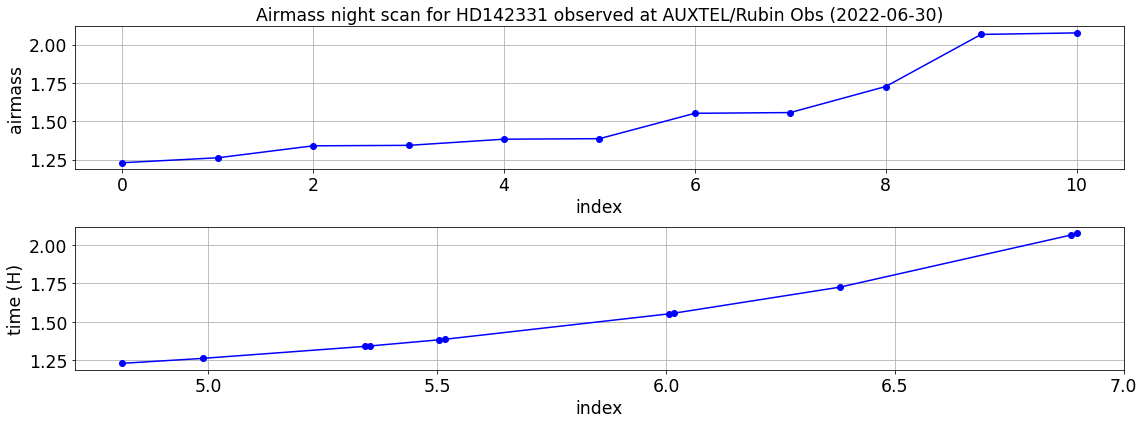

In [94]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_subplot(211)
ax1.plot(AirM,"bo-")
ax1.set_ylabel("airmass")
ax1.set_xlabel("index")
title=f"Airmass night scan for {target} observed at {SITE} ({DATE})"
ax1.set_title(title)
ax1.grid()


ax2=fig.add_subplot(212)
ax2.plot(Tim,AirM,"bo-")
ax2.set_ylabel("time (H)")
ax2.set_xlabel("index")
ax2.grid()

plt.tight_layout()

# Bouguer line

### Integration of SED in bin

In [95]:
wl_center=800.
wl_binwidth=WLBINWIDTH
wl_halfbinwidth=wl_binwidth/2.

In [96]:
def IntegSEDinBin(wl,sed,wlcenter,wlbinwidth=20):
    """
    """

    wlmin=wlcenter-wlbinwidth/2.
    wlmax=wlcenter+wlbinwidth/2.
       
    wl = wl
    fl = sed
          
    index_wl = np.where(np.logical_and(wl>=wlmin,wl<wlmax))[0]
    wl2= wl[index_wl]
    fl2= fl[index_wl]
  
    integ_fl = np.trapz(fl2,wl2) 
    #integ_fl = np.sum(fl2[:-1]*np.diff(wl2))          
    mags = -2.5*np.log10(integ_fl)
    
    return integ_fl, mags, wl2,fl2
    

Text(0, 0.5, '$d\\lambda$ (nm)')

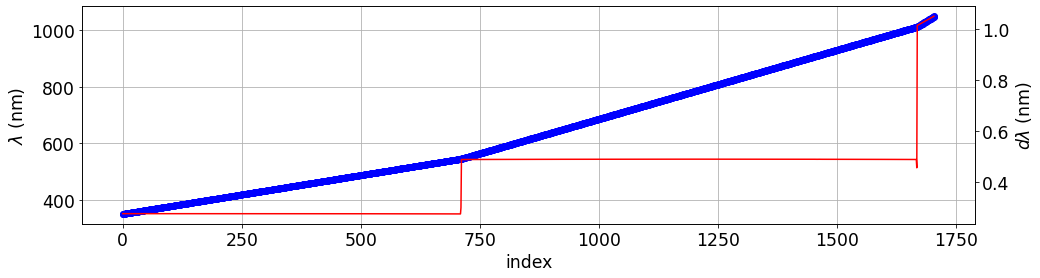

In [97]:
fig=plt.figure(figsize=(16,4))
ax=fig.add_subplot(1,1,1)
ax.plot(sed_w,'bo-')
ax.grid()
ax.set_ylabel("$\lambda$ (nm)")
ax.set_xlabel("index")
ax2 = ax.twinx()
ax2.plot(np.diff(sed_w),"r-")
ax2.set_ylabel("$d\lambda$ (nm)")

## Must interpolate SED

In [98]:
WL_SED = np.arange(sed_w.min(),sed_w.max(),0.1)

In [99]:
fcn_sed = interpolate.interp1d(sed_w,sed_f,bounds_error=False,fill_value=(0,0))

In [100]:
sed_integ_fl,sed_integ_mag, sed_wl_bin,sed_fl_bin = IntegSEDinBin(WL_SED,fcn_sed(WL_SED),wl_center,wlbinwidth=WLBINWIDTH)

Text(0.5, 0.98, '$\\lambda$ = 800.0 $\\pm$ 15.0 nm')

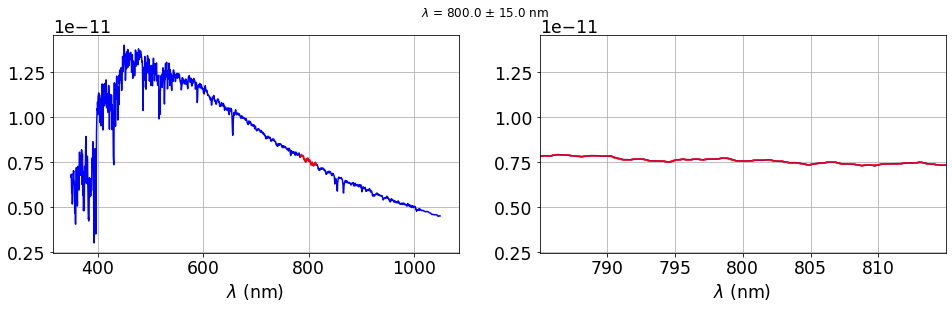

In [101]:
fig=plt.figure(figsize=(16,4))
ax= fig.add_subplot(121)             
ax.plot(sed_w,sed_f,'b-')
ax.plot(sed_wl_bin,sed_fl_bin,'r-')
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax= fig.add_subplot(122)             
ax.plot(sed_w,sed_f,'b-')
ax.step(sed_wl_bin,sed_fl_bin,'r-')
ax.set_xlim(sed_wl_bin[0],sed_wl_bin[-1])
ax.set_xlabel("$\lambda$ (nm)")
ax.grid()
title=f"$\lambda$ = {wl_center} $\pm$ {wl_halfbinwidth} nm"
plt.suptitle(title)

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_82362/3688564766.py:17: RuntimeWarning: divide by zero encountered in log10
  mags = -2.5*np.log10(integ_fl)


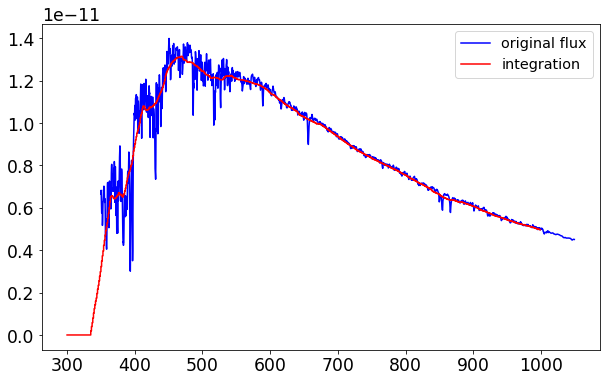

In [102]:
wl_binwidth=30.0
all_wl_center = np.arange(300.,1000.,1)
all_sed_integ_flux = np.zeros(len(all_wl_center))
idx=0
for wl0 in all_wl_center:
    sed_integ_fl,sed_integ_mag, sed_wl_bin,sed_fl_bin = IntegSEDinBin(WL_SED,fcn_sed(WL_SED),wl0,wlbinwidth=WLBINWIDTH)
    all_sed_integ_flux[idx] = sed_integ_fl
    idx+=1

plt.plot(sed_w,sed_f,'b-',label="original flux")    
plt.step(all_wl_center,all_sed_integ_flux/wl_binwidth,'r-',label='integration')
plt.legend()    

### Integration of measured flux

In [103]:
def ComputeOneBouguerLine(infos,all_spectra,wlcenter,wlbinwidth=20):
    """
    """

    wlmin=wlcenter-wlbinwidth/2.
    wlmax=wlcenter+wlbinwidth/2.
    
    airmasses = infos["airmass"].values
    numbers = infos["number"].values
    
    N=len(all_spectra)
    
    fluxes = np.zeros(N)
    efluxes = np.zeros(N)
    
    
    
    idx=0
    for spec in all_spectra:
        wl = spec["all_lambdas"].values
        fl = spec["all_fluxes"].values
        efl = spec["all_fluxes_err"].values
        
        index_wl = np.where(np.logical_and(wl>=wlmin,wl<wlmax))[0]
        wl2= wl[index_wl]
        fl2= fl[index_wl]
        efl2= efl[index_wl]
        
        integ_fl = np.trapz(fl2,wl2) # compute np.sum(fl2[:-1]*np.diff(wl2))
        integ_efl2 = np.trapz(efl2**2,wl2) # np.sum((efl2**2)[:-1]*np.diff(wl2))
        integ_efl = np.sqrt(integ_efl2)
        
        fluxes[idx] = integ_fl
        efluxes[idx] = integ_efl
 
        
        idx+=1
        
    mags = -2.5*np.log10(fluxes)
    emags = 2.5/np.log(10)*efluxes/fluxes
    
    return airmasses,numbers,fluxes,efluxes,mags,emags
    

In [104]:
wl_center0=800.
wl_halfbinwidth=WLBINWIDTH/2.

In [105]:
airmasses,numbers,fluxes,efluxes,mags,emags = ComputeOneBouguerLine(infos,all_spectra,wlcenter=wl_center0,wlbinwidth=WLBINWIDTH)

# Fits methods

https://stackoverflow.com/questions/62460399/comparison-of-curve-fit-and-scipy-odr-absolute-sigma

In [106]:
def func_straightlinemodel(x,*param):
    """
    Function to fit a straight file
    Must be used with curve_fit
    input args: 
    - y = f(x) = a0 + a1x
     
    """    
    a0 = param[0]
    a1 = param[1]
    return a0 + a1*x

In [107]:
def func_straightlinemodel2(param,x):
    """
    Function to fit a straight file
    Must be used with ODR
    input args: 
    - y = f(x) = a0 + a1x
     
    """      
    a0,a1 = param
    return a0 + a1*x

In [108]:
def func_straightlinemodel3(x,a0,a1):
    """
    Function to fit a straight file.
    Must be used with iMinuit
    
    input args: 
    - y = f(x) = a0 + a1x
     
    """    
    return a0 + a1*x

In [109]:
def func_straightlinemodel4(x, params):
    """
    Function to fit a straight file.
    Must be used with iMinuit
    
    input args: 
    - y = f(x) = a0 + a1x
    """
    return np.polyval(params, x)  # for len(par) == 2, this is a line

In [110]:
def StraightlineFit(X,Y,EY):
    """
    Exact calculation
    Fit Y  = a0 + a1 X
    """
    
    SN = ((1/EY)**2).sum()
    SX = (X*(1/EY)**2).sum()
    SXY = (X*Y*(1/EY)**2).sum()
    SXX = ((X/EY)**2).sum()
    SY = (Y*(1/EY)**2).sum()
    
    D = SN*SXX - SX**2
    a0 = (SXX*SY - SX*SXY)/D
    a1 = (SN*SXY-SX*SY)/D
    
    popt = np.array([a0,a1])
    
    sigma_a0_2 = SXX/D
    sigma_a1_2 = SN/D
    
    
    return popt, np.array([sigma_a0_2, sigma_a1_2])

In [111]:
def FitAndPlot(X,Y,EY,tags,wl0,wlw,FLAG_PLOT=True,xlabel="airmass",ylabel="magnitude",fitmethod="curve_fit"):
    """
    Fit and Plot a straight line according different methods
    
    input args :
      - X : the independent variable
      - Y : the dependent variable (Y = f(X) )
      - EY : the error on Y
      - wl0 : central wavelength of the data slice bin (info for plotting)
      - wlw : bin sie wavelength of the data slice (info for plotting)
      - FLAG_PLOT : flag to activate the plotting
      - xlabel : abscisse label of the plot
      - ylabel : ordinate label of the plot
      - fitmethod : name of the fit procedure
              - curve_fit
              - polyfit
              - ODR
              - iMinuit
              - matrix
              - default (no covariance)
      
      
    return:
      - intercept of the fit
      - slope of the fit
      - x_fit : abcisses of the points of the fitted straight line
      - y_fit : ordinates of the points of the fitted straight line
      - sigmaf : error on the fitted straight line
      - y_fit_up : upper value  for the error bar
      - y_fit_dw  : lower value for the error bar
    
    
    """
    
    N=len(X)
    # wavelength bin colors
    
    # fit
    the_X = np.copy(X)
    the_Y = np.copy(Y)
    the_EY = np.copy(EY)
    the_EX = np.zeros(len(X)) + 0.0000000001
    
      
    # straight line
    x_fit = np.linspace(0,the_X.max()+0.5,200)
    
    if fitmethod == "curve_fit":
        #p(x) = p[0] + p[1] * x
        # If use absolute_sigma=False, we get same results as polyfit (non point errors)
        # If use absolute_sigma=True, we really apply the errors on points and have the real covariance
        popt,pcov = curve_fit(func_straightlinemodel, the_X, the_Y, p0=[0,0], sigma =the_EY,absolute_sigma=True)
        y_fit= func_straightlinemodel(x_fit,*popt)
        intercept =  popt[0] # index 1
        slope     =  popt[1] # index 0 
        # sigma^2 = (dp(x)/dp0)^2 sigma(p0)^2  + (dp(x)/dp1)^2 sigma(p1)^2 + 2(dp(x)/dp0).(dp(x)/dp1) cov(p0,p1)
        # sigma^2 = sigma(p0)^2  + x^2*sigma(p1)^2 + 2*x*cov(p0,p1)       
        sigmaf=np.sqrt(pcov[0,0]+pcov[1,1]*x_fit**2 +x_fit*(pcov[0,1]+pcov[1,0]))
        residuals = (the_Y - func_straightlinemodel(the_X,*popt))
        chi_arr =  residuals / the_EY
        chi2_red = (chi_arr**2).sum() / (len(the_X)-len(popt))
        sigmaf *= np.sqrt(chi2_red)
        #print("curve_fit")
        #print("popt   = ",popt)
        #print("pcov   = ",pcov)
        #print("y_fit  = ",y_fit)
        #print("sigmaf = ",sigmaf)
        
        
    elif fitmethod == "polyfit":
        #p(x) = p[0] * x + p[1]
        popt,pcov = np.polyfit(the_X, the_Y, 1,cov=True)
        p = np.poly1d(popt) 
        y_fit= p(x_fit)
        intercept =  popt[-1]
        slope =  popt[0]
        # sigma^2 = (dp(x)/dp0)^2 sigma(p0)^2  + (dp(x)/dp1)^2 sigma(p1)^2 + 2(dp(x)/dp0).(dp(x)/dp1) cov(p0,p1)
        # sigma^2 = x^2.sigma(p0)^2  + sigma(p1)^2 + 2*x*cov(p0,p1)
        sigmaf=np.sqrt(x_fit**2*pcov[0,0]+pcov[1,1]+x_fit*(pcov[0,1]+pcov[1,0]))
        residuals = (the_Y - p(the_X))
        chi_arr =  residuals / the_EY
        chi2_red = (chi_arr**2).sum() / (len(the_X)-len(popt))
        #sigmaf *= np.sqrt(chi2_red)
        #print("polyfit")
        #print("popt   = ",popt)
        #print("pcov   = ",pcov)
        #print("y_fit  = ",y_fit)
        #print("sigmaf = ",sigmaf)
    elif fitmethod == "ODR":
        linear_model = Model(func_straightlinemodel2)
        data = RealData(the_X, the_Y, sx=the_EX, sy=the_EY)
        odr = ODR(data, linear_model, beta0=[29, 0.5])
        out = odr.run()  
        popt = out.beta
        pcov = out.cov_beta
        y_fit= func_straightlinemodel2(popt,x_fit)
        intercept =  popt[0] # index 1
        slope =  popt[1]     # index 0 
        sigmaf=np.sqrt(pcov[0,0]+pcov[1,1]*x_fit**2 +x_fit*(pcov[0,1]+pcov[1,0]))
        residuals = (the_Y - func_straightlinemodel2(popt,the_X))
        chi_arr =  residuals / the_EY
        chi2_red = (chi_arr**2).sum() / (len(the_X)-len(popt))
        sigmaf *= np.sqrt(chi2_red)
    elif fitmethod =="iMinuit":
        # iminuit contains a LeastSquares class to conveniently generate a least-squares cost function.
        least_squares = LeastSquares(the_X, the_Y, the_EY, func_straightlinemodel4)
        m = Minuit(least_squares, [0,0],name=["a1","a0"] )  # first parameter is the slope, second parameter is the intercept

        m.migrad()  # finds minimum of least_squares function
        m.hesse()   # accurately computes uncertainties
        param_dict = m.values.to_dict()
        popt = np.array(list(param_dict.values()))
        pcov = np.array(m.covariance.data.tolist())
        y_fit=func_straightlinemodel4(x_fit, np.array(list(m.values.to_dict().values())))
        intercept = popt[1] # index 1
        slope =  popt[0]     # index 0 
        sigmaf=np.sqrt(x_fit**2*pcov[0,0]+pcov[1,1]+x_fit*(pcov[0,1]+pcov[1,0]))
        residuals = (the_Y - func_straightlinemodel4(the_X,popt))
        chi_arr =  residuals / the_EY
        chi2_red = (chi_arr**2).sum() / (len(the_X)-len(popt))
        sigmaf *= np.sqrt(chi2_red)
    elif fitmethod == 'matrix':
        # https://stackoverflow.com/questions/12783611/need-python-polynomial-fit-function-that-returns-covariance
        # do the fit
        polydeg = 1
        A = np.vstack([1 / the_EY] + [the_X ** _ / the_EY for _ in range(1, polydeg + 1)]).T
        popt = linalg.lstsq(A, (the_Y / the_EY))[0]
        pcov = np.matrix(np.dot(A.T, A)).I
        intercept =  popt[0] # index 0
        slope =  popt[1]     # index 1
        #y_fit= func_straightlinemodel4(x_fit,popt[:-1])
        y_fit = intercept + slope*x_fit
        # sigma^2 = (dp(x)/dp0)^2 sigma(p0)^2  + (dp(x)/dp1)^2 sigma(p1)^2 + 2(dp(x)/dp0).(dp(x)/dp1) cov(p0,p1)
        # sigma^2 = sigma(p0)^2  + sigma(p1)^2*x  
        sigmaf=np.sqrt(pcov[0,0]+pcov[1,1]*x_fit**2+x_fit*(pcov[0,1]+pcov[1,0]))
        #residuals = (the_Y - func_straightlinemodel4(the_X,popt[:-1]))
        residuals = (the_Y - intercept -slope*the_X)
        chi_arr =  residuals / the_EY
        chi2_red = (chi_arr**2).sum() / (len(the_X)-len(popt))
        sigmaf *= np.sqrt(chi2_red)
        
    else:
        # Home made analytical calculation
        # y = a0 + a1 x
        print(f"Unknown fitmethod = {fitmethod}")
        fitmethod ="Analytical calculation"
        popt,sigma2 = StraightlineFit(the_X,the_Y,the_EY)
        intercept =  popt[0] # index 0
        slope =  popt[1]     # index 1
        #y_fit= func_straightlinemodel4(x_fit,popt[:-1])
        y_fit = intercept + slope*x_fit
        # sigma^2 = (dp(x)/dp0)^2 sigma(p0)^2  + (dp(x)/dp1)^2 sigma(p1)^2 + 2(dp(x)/dp0).(dp(x)/dp1) cov(p0,p1)
        # sigma^2 = sigma(p0)^2  + sigma(p1)^2*x  
        sigmaf=np.sqrt(sigma2[0]+sigma2[1]*x_fit**2)
        #residuals = (the_Y - func_straightlinemodel4(the_X,popt[:-1]))
        residuals = (the_Y - intercept -slope*the_X)
        chi_arr =  residuals / the_EY
        chi2_red = (chi_arr**2).sum() / (len(the_X)-len(popt))
        sigmaf *= np.sqrt(chi2_red)
        

    
    nstd=1
    
    y_fit_up=y_fit+nstd*sigmaf
    y_fit_dw=y_fit-nstd*sigmaf

    y_scale = y_fit.max()-y_fit.min()
    y_shift = y_scale/8.
    
 
    
    if FLAG_PLOT:
        jet = plt.get_cmap('jet')
        cNorm_points = colors.Normalize(vmin=0, vmax=N)
        scalarMap_points = cmx.ScalarMappable(norm=cNorm_points, cmap=jet)
        all_colors_points = scalarMap_points.to_rgba(np.arange(N), alpha=1)
        
        
        textstr = '\n'.join((r'$\chi^2_{red}=%.1f$' % (chi2_red, ),r'$slope=%.3f$' % (slope, ),r'$intercept=%.3f$' % (intercept,)))
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
      
        
        fig = plt.figure(figsize=(16,4))
        ax=fig.add_subplot(111)
        ax.scatter(the_X,the_Y,s=100,color=all_colors_points)
        ax.errorbar(the_X,the_Y, yerr=the_EY, xerr=None, fmt='.',color="k",ecolor="grey", elinewidth=2, capsize=.01)
        label = f"$\lambda$ = {wl0:.0f} $\pm$ {wlw:.0f} nm"
        ax.plot(x_fit,y_fit,'k-',label=label)
        ax.fill_between(x_fit,y_fit_up , y_fit_dw , alpha=.25, color="gray")
        ax.legend() 
        ax.set_xlim(x_fit.min(),x_fit.max())
        ax.set_ylim(y_fit.min(),y_fit.max())
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(fitmethod)
        
        # place a text box in upper left in axes coords
        ax.text(0.8, 0.35, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        
        
        for index in range(N):
            textstr= str(tags[index])
            if index%2 == 0:
                dy = y_shift
            else:
                dy = -y_shift
            
            ax.text(the_X[index], the_Y[index] + dy , textstr,fontsize=14,fontweight="bold",ha='center',color=all_colors_points[index] )
                
        plt.show()
    return intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw


## Plot & test  Bouguer line

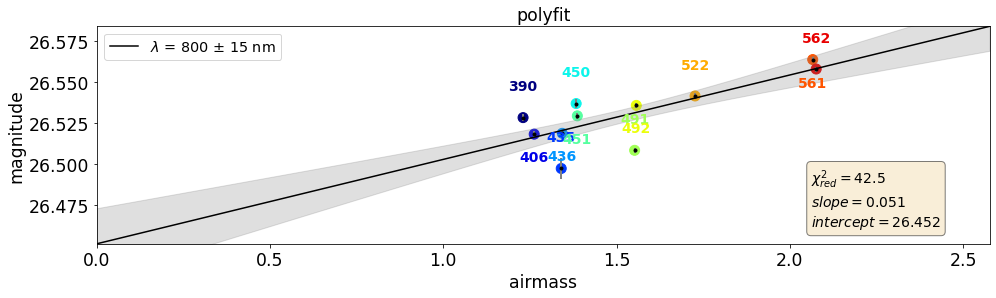

In [112]:
intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl_center0,wl_halfbinwidth,FLAG_PLOT=True,xlabel="airmass",ylabel="magnitude",fitmethod="polyfit")

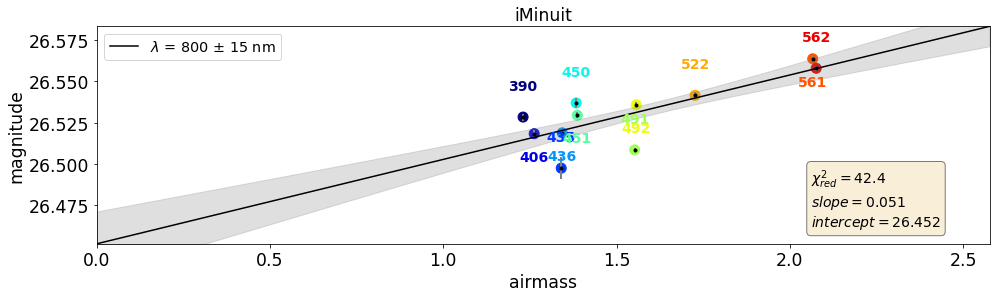

In [113]:
intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl_center0,wl_halfbinwidth,FLAG_PLOT=True,xlabel="airmass",ylabel="magnitude",fitmethod="iMinuit")

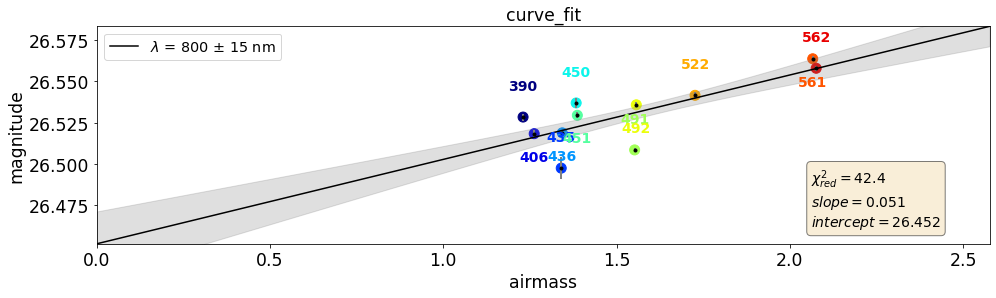

In [114]:
intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl_center0,wl_halfbinwidth,FLAG_PLOT=True,xlabel="airmass",ylabel="magnitude",fitmethod="curve_fit")

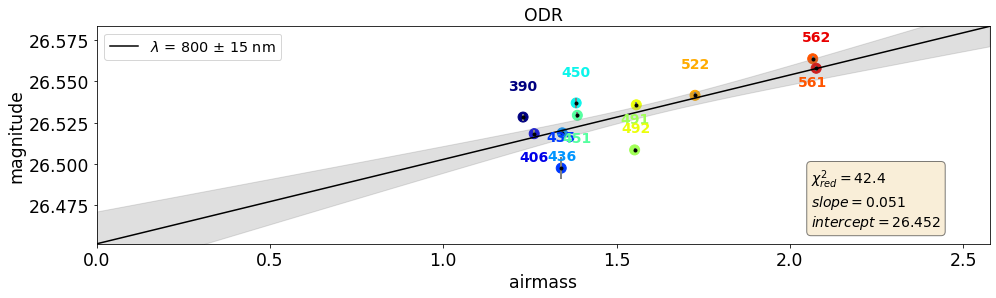

In [115]:
intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl_center0,wl_halfbinwidth,FLAG_PLOT=True,xlabel="airmass",ylabel="magnitude",fitmethod="ODR")

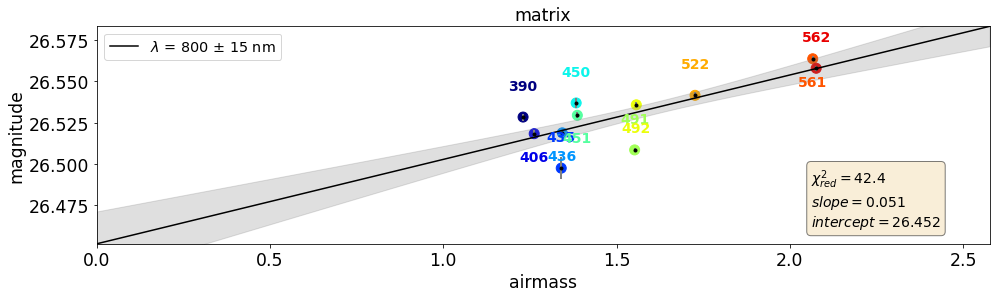

In [116]:
intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl_center0,wl_halfbinwidth,FLAG_PLOT=True,xlabel="airmass",ylabel="magnitude",fitmethod="matrix")

Unknown fitmethod = -


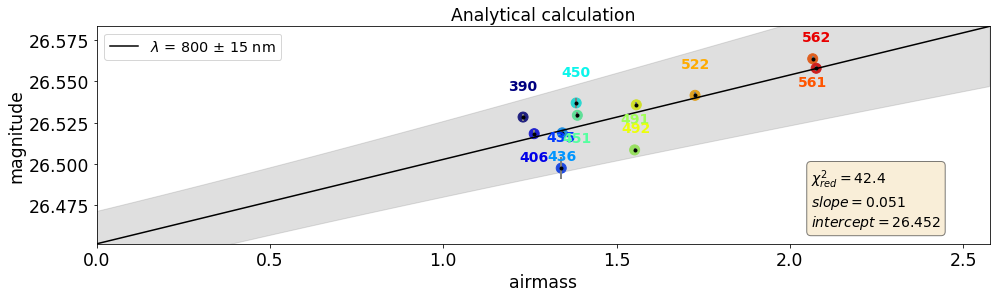

In [117]:
intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl_center0,wl_halfbinwidth,FLAG_PLOT=True,xlabel="airmass",ylabel="magnitude",fitmethod="-")

###  See many bouguer lines

In [118]:
#all_wl_center = np.arange(370.,1050.,30.)
all_wl_center = np.linspace(360,1050,NPOINTSVIEW)  
NAIR = len(infos)
NWL = NPOINTSVIEW

In [119]:
all_the_mags = np.zeros((NAIR,NWL))

In [120]:
idx=0
for wl0 in all_wl_center:
    airmasses,numbers,fluxes,efluxes,mags,emags = ComputeOneBouguerLine(infos,all_spectra,wlcenter=wl0,wlbinwidth=WLBINWIDTH)
    all_the_mags[:,idx] = mags
    idx+=1

Text(0.5, 1.0, 'Check ComputeOneBouguerLine in bands $\\delta \\lambda$ = 30.0')

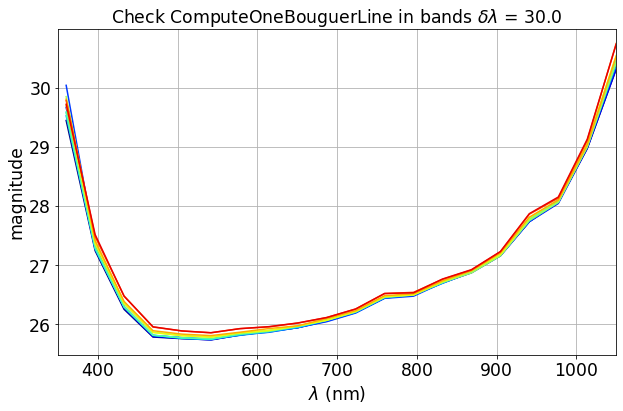

In [121]:
 # wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NAIR )
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors_air = scalarMap.to_rgba(np.arange(NAIR), alpha=1)  
for ia in range(NAIR):
    plt.plot(all_wl_center,all_the_mags[ia,:],'-',color=all_colors_air[ia])
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("magnitude")
plt.xlim(350,1050)
plt.title(f'Check ComputeOneBouguerLine in bands $\delta \lambda$ = {WLBINWIDTH}')

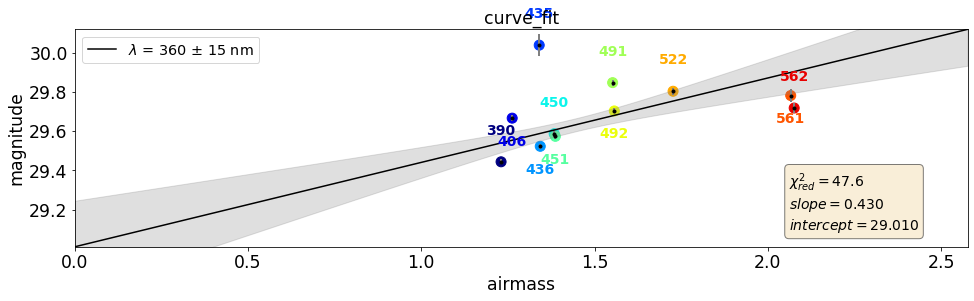

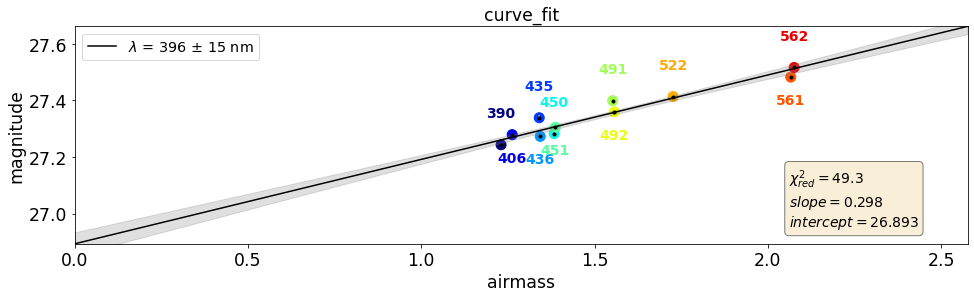

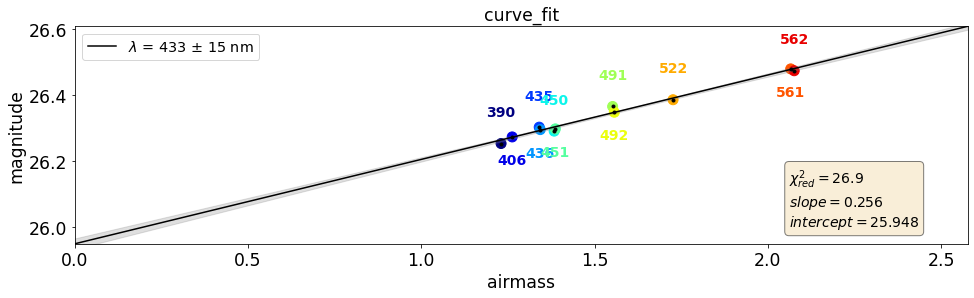

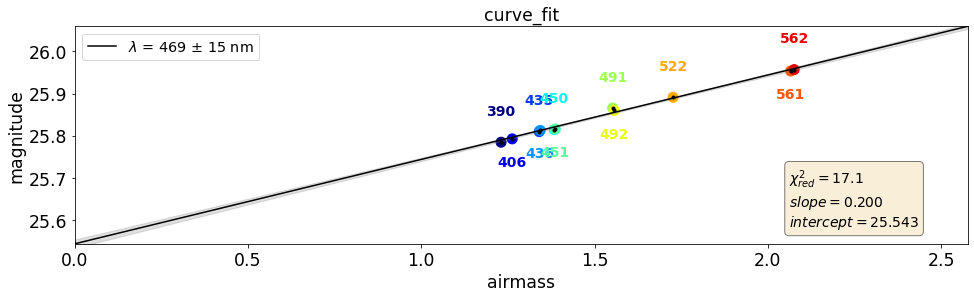

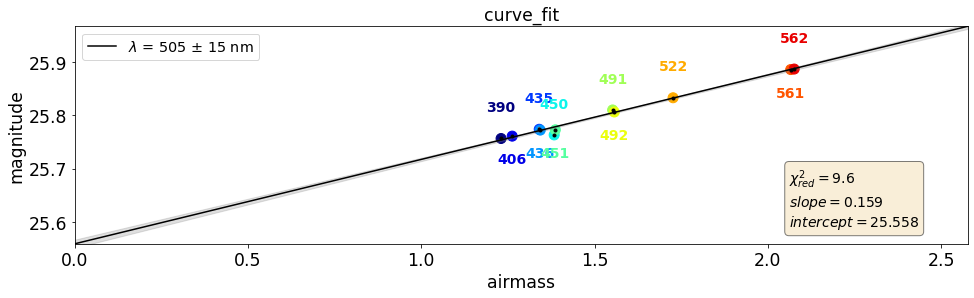

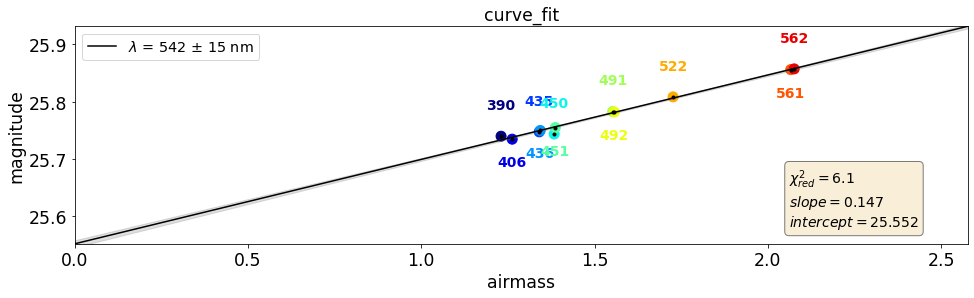

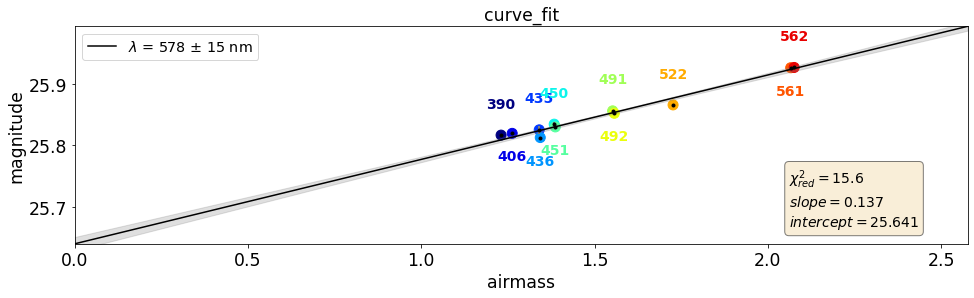

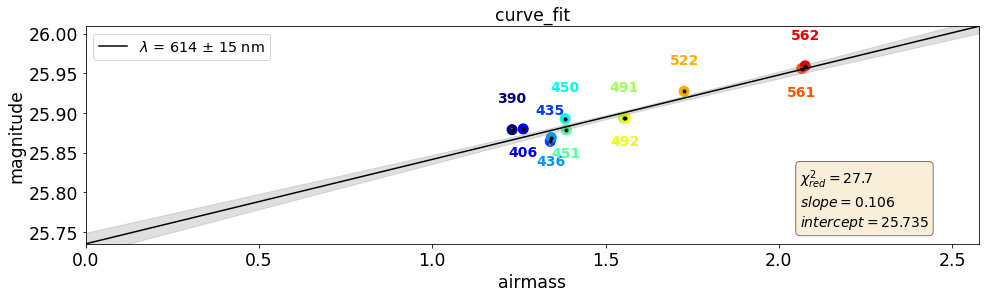

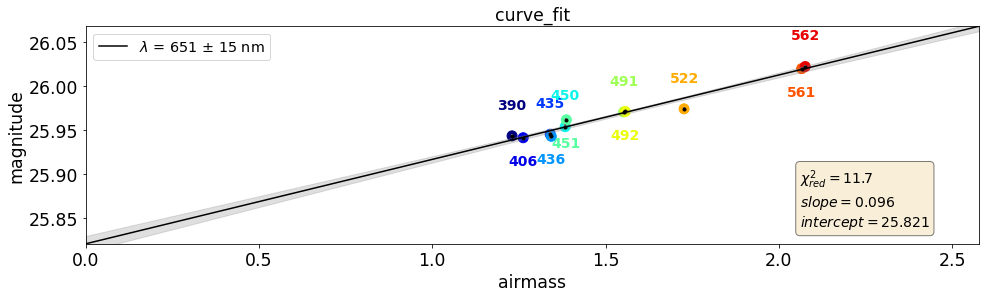

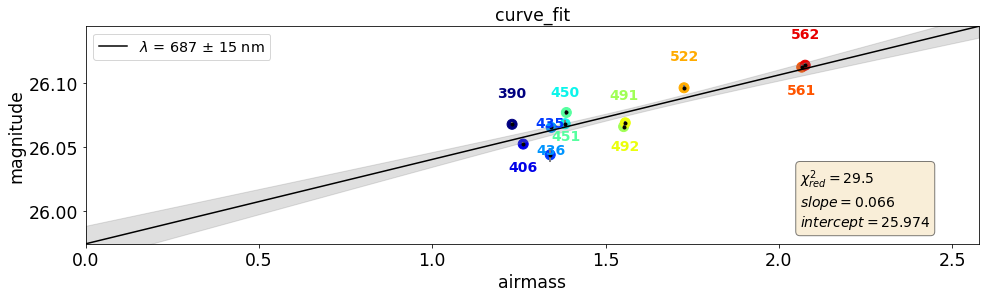

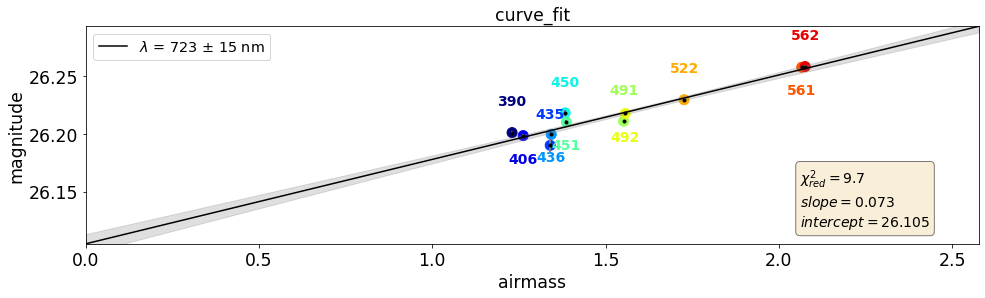

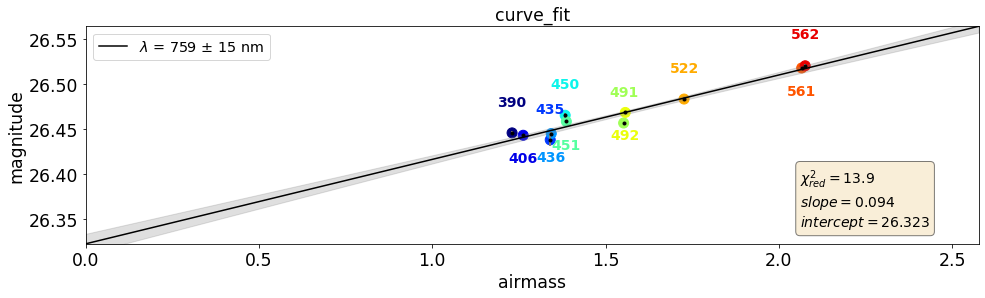

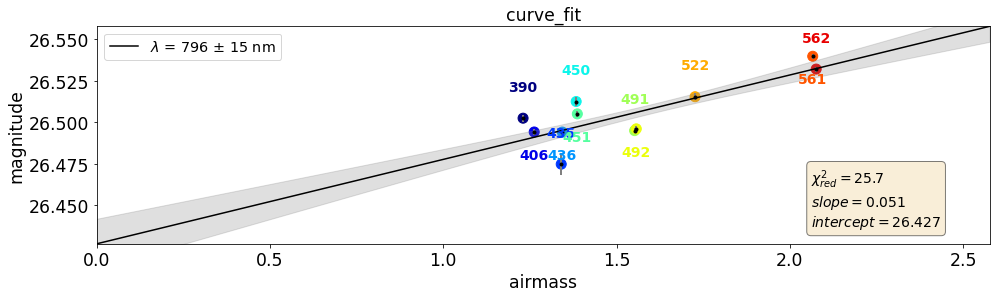

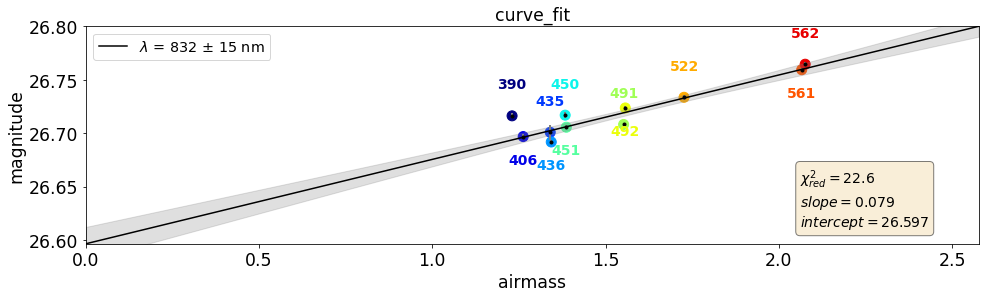

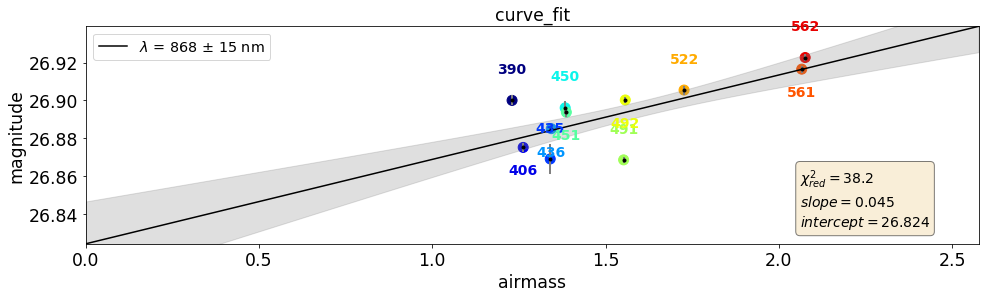

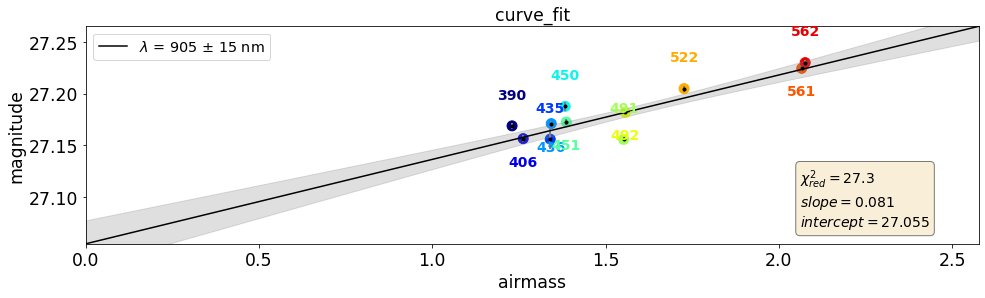

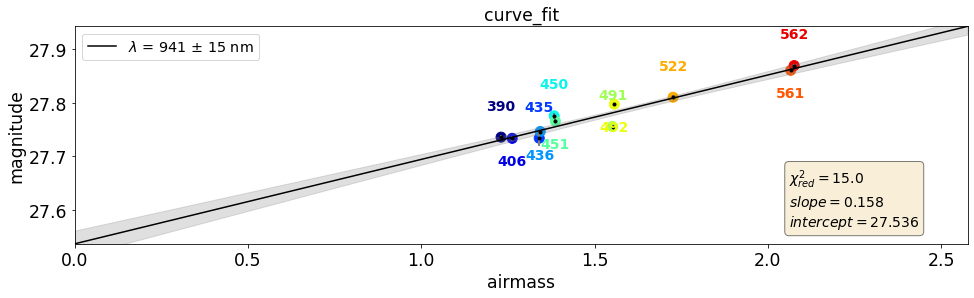

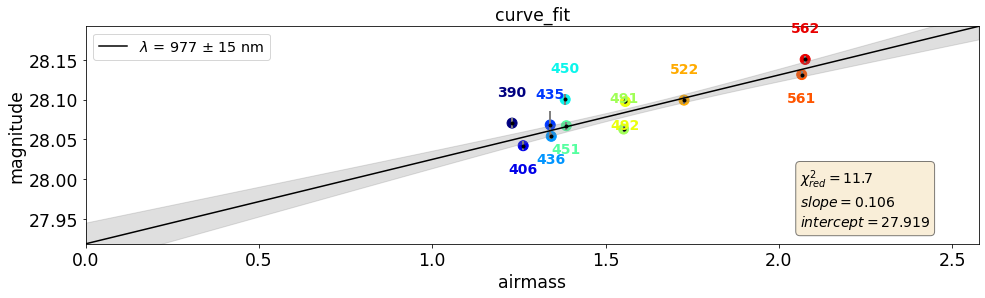

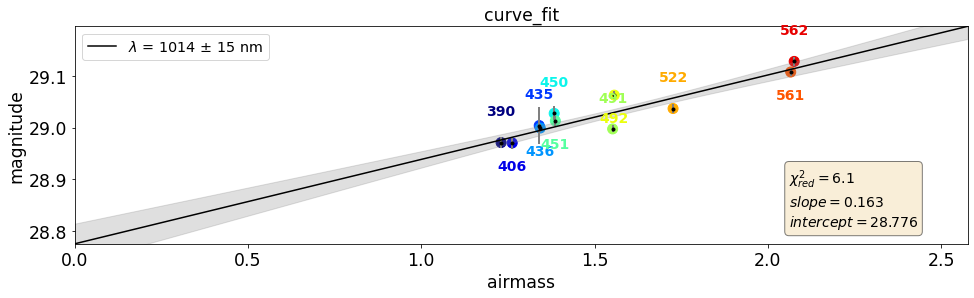

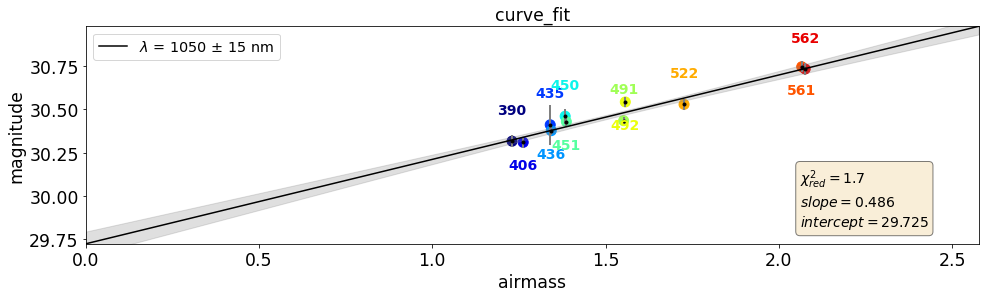

In [122]:
for wl0 in all_wl_center:
    airmasses,numbers,fluxes,efluxes,mags,emags = ComputeOneBouguerLine(infos,all_spectra,wlcenter=wl0,wlbinwidth=WLBINWIDTH)
    intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl0,wl_halfbinwidth,FLAG_PLOT=True,xlabel="airmass",ylabel="magnitude",fitmethod="curve_fit") 

## All Bouguer lines from integrated measured flux

Text(0.5, 1.0, 'Bouguer lines : measured magnitude vs airmass, $\\Delta \\lambda$=30.0nm, 2022-06-30,AUXTEL/Rubin Obs')

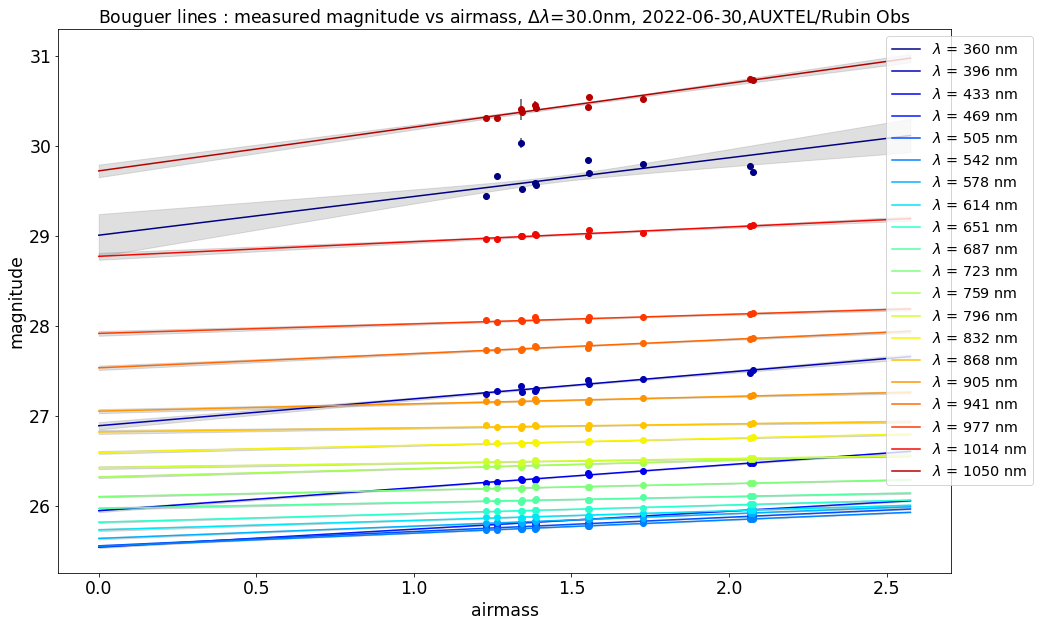

In [123]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)

NWL = len(all_wl_center)
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

idx=0
for wl0 in all_wl_center:
    airmasses,number,fluxes,efluxes,mags,emags = ComputeOneBouguerLine(infos,all_spectra,wlcenter=wl0,wlbinwidth=WLBINWIDTH)
    intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,number,wl0,wl_halfbinwidth,FLAG_PLOT=False,xlabel="airmass",ylabel="magnitude",fitmethod="curve_fit")
    
    #print(y_fit)
    ax.errorbar(airmasses,mags, yerr=emags, xerr=None, fmt='o',color=all_colors[idx],ecolor="grey", elinewidth=2, capsize=.01)
    label = f"$\lambda$ = {wl0:.0f} nm"
    ax.plot(x_fit,y_fit,'-',color=all_colors[idx],label=label)
    ax.fill_between(x_fit,y_fit_up , y_fit_dw , alpha=.25, color="gray")
   
    idx+=1
    
ax.legend(loc="upper right",bbox_to_anchor=(1.1,1))    
ax.set_xlabel("airmass")
ax.set_ylabel("magnitude")  
title = f"Bouguer lines : measured magnitude vs airmass, $\Delta \lambda$={wl_binwidth}nm, {DATE},{SITE}"
ax.set_title(title)

## All Bouguer lines from measured integrated flux - integrated SED

Text(0.5, 1.0, 'Bouguer lines : measured magnitude - sed mag vs airmass, $\\Delta \\lambda$=30.0nm, 2022-06-30,AUXTEL/Rubin Obs')

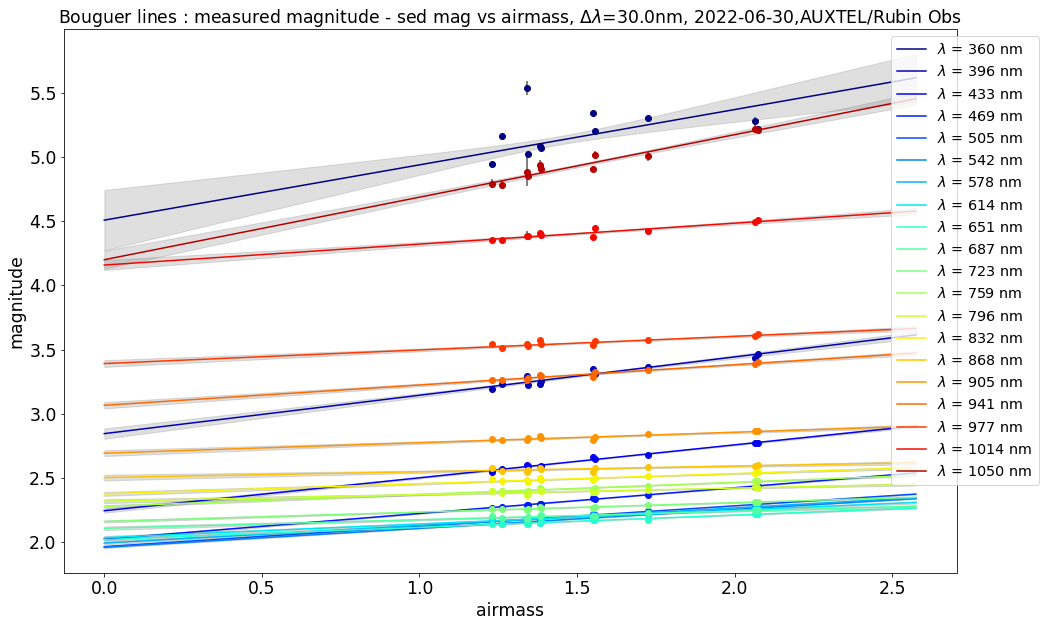

In [124]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)

NWL = len(all_wl_center)
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

idx=0
for wl0 in all_wl_center:
    sed_integ_fl,sed_integ_mag, sed_wl_bin,sed_fl_bin = IntegSEDinBin(sed_w,sed_f,wl0,wlbinwidth=WLBINWIDTH)
    airmasses,numbers,fluxes,efluxes,mags,emags = ComputeOneBouguerLine(infos,all_spectra,wlcenter=wl0,wlbinwidth=WLBINWIDTH)
    intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl0,wl_halfbinwidth,FLAG_PLOT=False,xlabel="airmass",ylabel="magnitude",fitmethod="curve_fit")
    
    ax.errorbar(airmasses,mags-sed_integ_mag, yerr=emags, xerr=None, fmt='o',color=all_colors[idx],ecolor="grey", elinewidth=2, capsize=.01)
    label = f"$\lambda$ = {wl0:.0f} nm"
    ax.plot(x_fit,y_fit-sed_integ_mag,'-',color=all_colors[idx],label=label)
    ax.fill_between(x_fit,y_fit_up-sed_integ_mag , y_fit_dw-sed_integ_mag , alpha=.25, color="gray")
    idx+=1
    
ax.legend(loc="upper right",bbox_to_anchor=(1.1,1))    
ax.set_xlabel("airmass")
ax.set_ylabel("magnitude")  
title = f"Bouguer lines : measured magnitude - sed mag vs airmass, $\Delta \lambda$={wl_binwidth}nm, {DATE},{SITE}"
ax.set_title(title)

# Throughput

In [125]:
#correction_area = 1.06/1.13

In [126]:
all_wl_center = np.linspace(350,1050,NPOINTSSAVE)

In [127]:
idx=0
N=len(all_wl_center)
transm = np.zeros(N)
transm0 = np.zeros(N)
etransm = np.zeros(N)
etransm0 = np.zeros(N)
idx=0
for wl0 in all_wl_center:
    sed_integ_fl,sed_integ_mag, sed_wl_bin,sed_fl_bin = IntegSEDinBin(WL_SED,fcn_sed(WL_SED),wl0,wlbinwidth=WLBINWIDTH)
    airmasses,numbers,fluxes,efluxes,mags,emags = ComputeOneBouguerLine(infos,all_spectra,wlcenter=wl0,wlbinwidth=WLBINWIDTH)
    intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl0,wl_halfbinwidth,FLAG_PLOT=False,xlabel="airmass",ylabel="magnitude",fitmethod="curve_fit")
    m = (y_fit-sed_integ_mag)[0]
    m0 = y_fit[0]
    em = sigmaf[0]
    transm[idx]=np.power(10,-m/2.5)/correction_area
    transm0[idx]=np.power(10,-m0/2.5)/correction_area
    etransm[idx]=em*transm[idx]/correction_area
    etransm0[idx]=em*transm0[idx]/correction_area
    idx+=1

(350.0, 1050.0)

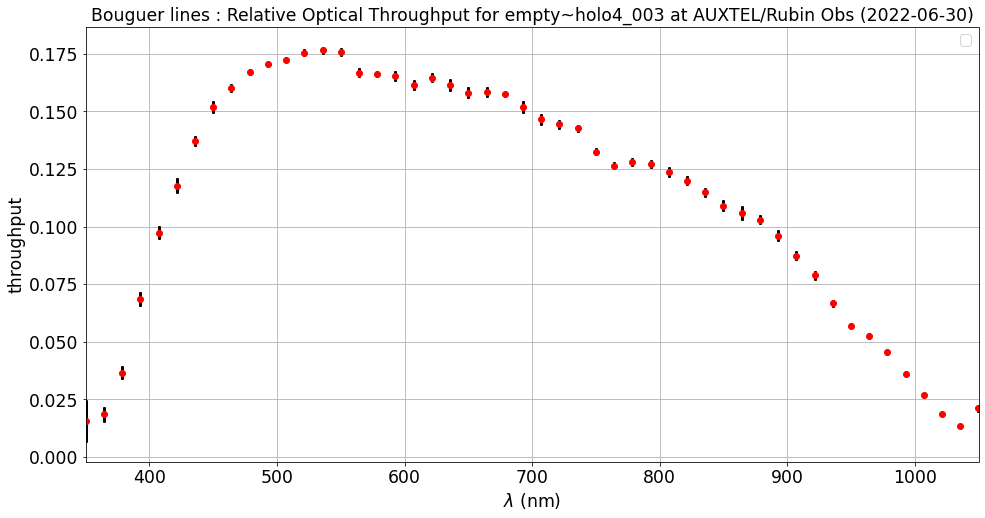

In [128]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)
X=all_wl_center
Y=transm
EY= etransm
ax.errorbar(X,Y, yerr=EY, xerr=None, fmt='o',color="r",ecolor="k", elinewidth=3, capsize=1)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Bouguer lines : Relative Optical Throughput for {filterdisperser} at {SITE} ({DATE})"
ax.set_title(title)
ax.grid()
ax.legend()
ax.set_xlim(WLMINSEL,WLMAXSEL)
        

# Spectrum above atmosphere

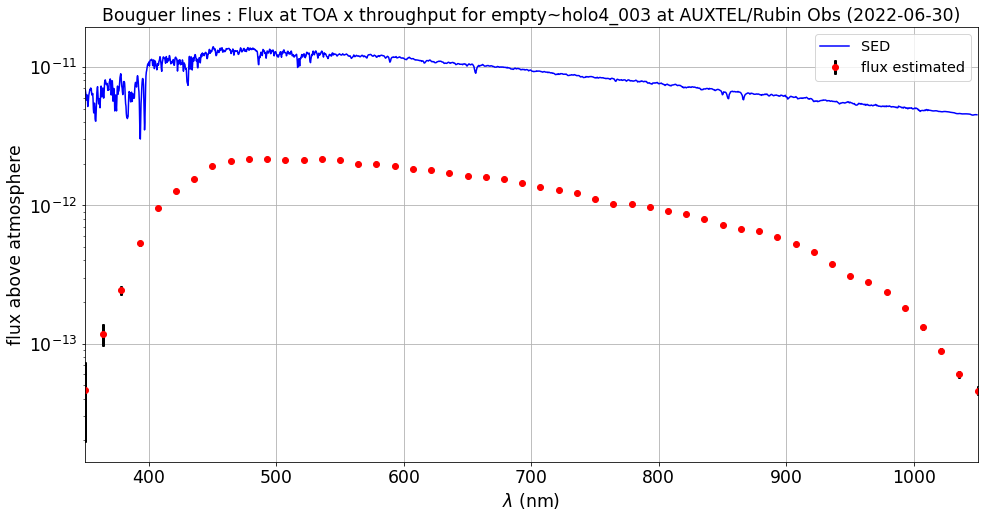

In [129]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)
X=all_wl_center
Y=transm0/wl_binwidth
EY= etransm0/wl_binwidth
ax.plot(sed_w,sed_f,'b-',label="SED")
ax.errorbar(X,Y, yerr=EY, xerr=None, fmt='o',color="r",ecolor="k", elinewidth=3, capsize=1,label="flux estimated")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux above atmosphere")
title=f"Bouguer lines : Flux at TOA x throughput for {filterdisperser} at {SITE} ({DATE})"
ax.set_title(title)
ax.grid()
ax.legend()
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_yscale('log')

# Save throuput and fluxes

In [130]:
dfout = pd.DataFrame()

In [131]:
dfout["wavelength"]=all_wl_center
dfout["throu"]=transm
dfout["errthrou"]=etransm
dfout["sedtoa"]=transm0/wl_binwidth
dfout["errsedtoa"]=etransm0/wl_binwidth

In [132]:
outputfile_linearfit

'MLfit_bouguer_linearfit-20220630-empty~holo4_003-config_DECONVOLUTION_PSF2DFFM_out.csv'

In [133]:
# Save CSV file
dfout.to_csv(outputfile_linearfit) 